# Data Statistics and Evaluation

In the following demo, we will:
* Calculate total number of hours recorded for each site and locate files which could not be read with TuneR's readwave function.
* Calculate Summary Statistcs for each Bioacoustic Index
* Visualization of Indices
* Cluster Analysis (for indices)
* Correlation Analysis (for indices)
* Cluster Analysis following Correlation Analysis. 

First we install the necessary packages and set the width/height of the plots:

In [41]:
library(tuneR)
library(tidyr)
library(ggplot2)
library(factoextra)
library(cluster)
library(plyr)
library(repr)
library(cowplot)
library(TSdist)
library(mclust)
options(repr.plot.width=15, repr.plot.height=8)

## Basic Sound Data Statistics and Data 

The following code gives the hours recorded at each site (along with the total. Uncommenting the the expressions in the warning/error brackets also gives the files which could not be processed using TuneR's readWave function along with why the function fails (8 failed files). Errors include:
* bin-reading error(2 files): ``` <simpleError in readBin(con, int, n = 4, size = 1, endian = "little", signed = FALSE) %*% 2^c(0, 8, 16, 24): non-conformable arguments> ```
* char-reading error(3 files): ``` <simpleError in readChar(con, 4): invalid UTF-8 input in readChar()> ```
* non-valid WAVE file(3 files): ``` <simpleError in readWave(soundfile, header = TRUE): This seems not to be a valid RIFF file of type WAVE.> ```


As shown below there is about 1,260 hours of usable recorded sound.

In [42]:
DATA_LIBRARY_PATH<- "/media/colton/My Passport/data_library"
file.paths <- list.files(DATA_LIBRARY_PATH)
total <- 0
nonproblem_files <- 0
total_files <- 0
for (i in 1:length(file.paths)){
  duration <- 0
  sitepath <- paste(DATA_LIBRARY_PATH,file.paths[i],sep='/')
  sitefiles <- list.files(sitepath,recursive=TRUE, pattern = "wav$")
  for (j in 1:length(sitefiles)){
    soundfile <- paste(sitepath,sitefiles[j],sep='/')
    total_files <- total_files + 1
    result <- tryCatch(expr={
    hdr <- readWave(soundfile,header=TRUE)
    sr <- hdr$sample.rate
    samples<-hdr$samples
    duration <- duration + samples/(sr*3600)
    nonproblem_files <- nonproblem_files + 1
    }, warning = function(w) {
      #print(w)
      #print(soundfile)
    }, error = function(e) {
      #print(e)
      #print(soundfile)
    })
}
  total <- duration + total
  print(paste(paste(file.paths[i],duration,sep=": "),"hours"))
}
print(paste("Total",total,sep=": "))
print(paste("Non-Problem Files",nonproblem_files,sep=": "))
print(paste("Total Files",total_files,sep=": "))

[1] "Audubon_Society: 29.3517748148148 hours"
[1] "Biosphere_2: 27.2658311111111 hours"
[1] "Chuparosa_Inn: 21.59808 hours"
[1] "Desert_museum: 39.1802755555556 hours"
[1] "Empire_Ranch: 24.7657748148148 hours"
[1] "Gates Pass: 123.29344 hours"
[1] "Jake: 91.3273303703704 hours"
[1] "Nirav: 95.5661096296297 hours"
[1] "Patagonia_lake: 25.5610548148148 hours"
[1] "Paton_Hummingbird: 24.87544 hours"
[1] "Proctor_road: 24.993522962963 hours"
[1] "Ruth: 111.326684444445 hours"
[1] "Sabino_canyon: 50.0686074074074 hours"
[1] "Saguaro_NP: 136.065831111111 hours"
[1] "Silvestrer_Spring: 24.6300503703704 hours"
[1] "Sweetwater: 140.433386666667 hours"
[1] "Theresa: 105.168971851852 hours"
[1] "Tumamoc: 163.181576296296 hours"
[1] "Total: 1258.65374222222"
[1] "Non-Problem Files: 1301"
[1] "Total Files: 1309"


## Index Stats and Clustering Analysis
The calculated indices are read in from a CSV(comma separated values) file.  The first six rows of the dataframe are shown below.

In [43]:
INDEX_CSV <- "/media/colton/My Passport/new_final.csv"
index_data <- read.csv(INDEX_CSV,header=TRUE)
index_data$acoustic_evenness....double..<-NULL
index_data$spectral_entropy....double..<-NULL
head(index_data)

Site            Date....as.Date.character....format.....Y..m..d..
1 Audubon_Society 2019-04-18                                       
2 Audubon_Society 2019-04-18                                       
3 Audubon_Society 2019-04-18                                       
4 Audubon_Society 2019-04-18                                       
5 Audubon_Society 2019-04-18                                       
6 Audubon_Society 2019-04-18                                       
  Time....character.. Name....character..                         
1 11:12:36            Audubon_Society_S4A07275_20190418_111236.wav
2 11:17:36            Audubon_Society_S4A07275_20190418_111236.wav
3 11:22:36            Audubon_Society_S4A07275_20190418_111236.wav
4 11:27:36            Audubon_Society_S4A07275_20190418_111236.wav
5 11:32:36            Audubon_Society_S4A07275_20190418_111236.wav
6 11:37:36            Audubon_Society_S4A07275_20190418_111236.wav
  File_Start_Time....character.. File_End_Time....character..
1  0                              5                          
2  5                             10                          
3 10                             15                          
4 15                             20                          
5 20                             25                          
6 25                             30                          
  bioacoustic....double.. amplitude....double.. temporal_entropy....double..
1 101.0132                0.09830943            0.9724801                   
2 113.4433                0.11335600            0.9730184                   
3 125.1966                0.20363086            0.9820155                   
4 147.6329                0.16143239            0.9848378                   
5 120.6462                0.18025170            0.9826372                   
6 150.6320                0.09876261            0.9809657                   
  acoustic_entropy....double.. acoustic_diversity....double..
1 0.7918867                    1.811299                      
2 0.7862678                    1.767159                      
3 0.7802612                    1.744127                      
4 0.7636971                    1.768792                      
5 0.7834478                    1.733753                      
6 0.7845571                    1.580442                      
  acoustic_complexity....double.. nrows....double.. ndsi....double..
1 196.6844                        1                 0.4799106       
2 201.1060                        0                 0.8579672       
3 196.8785                        0                 0.5911719       
4 211.8268                        0                 0.8497890       
5 199.5438                        1                 0.5483259       
6 191.5337                        0                 0.7192530

A generic histogram is plotted for each of the alpha indices.

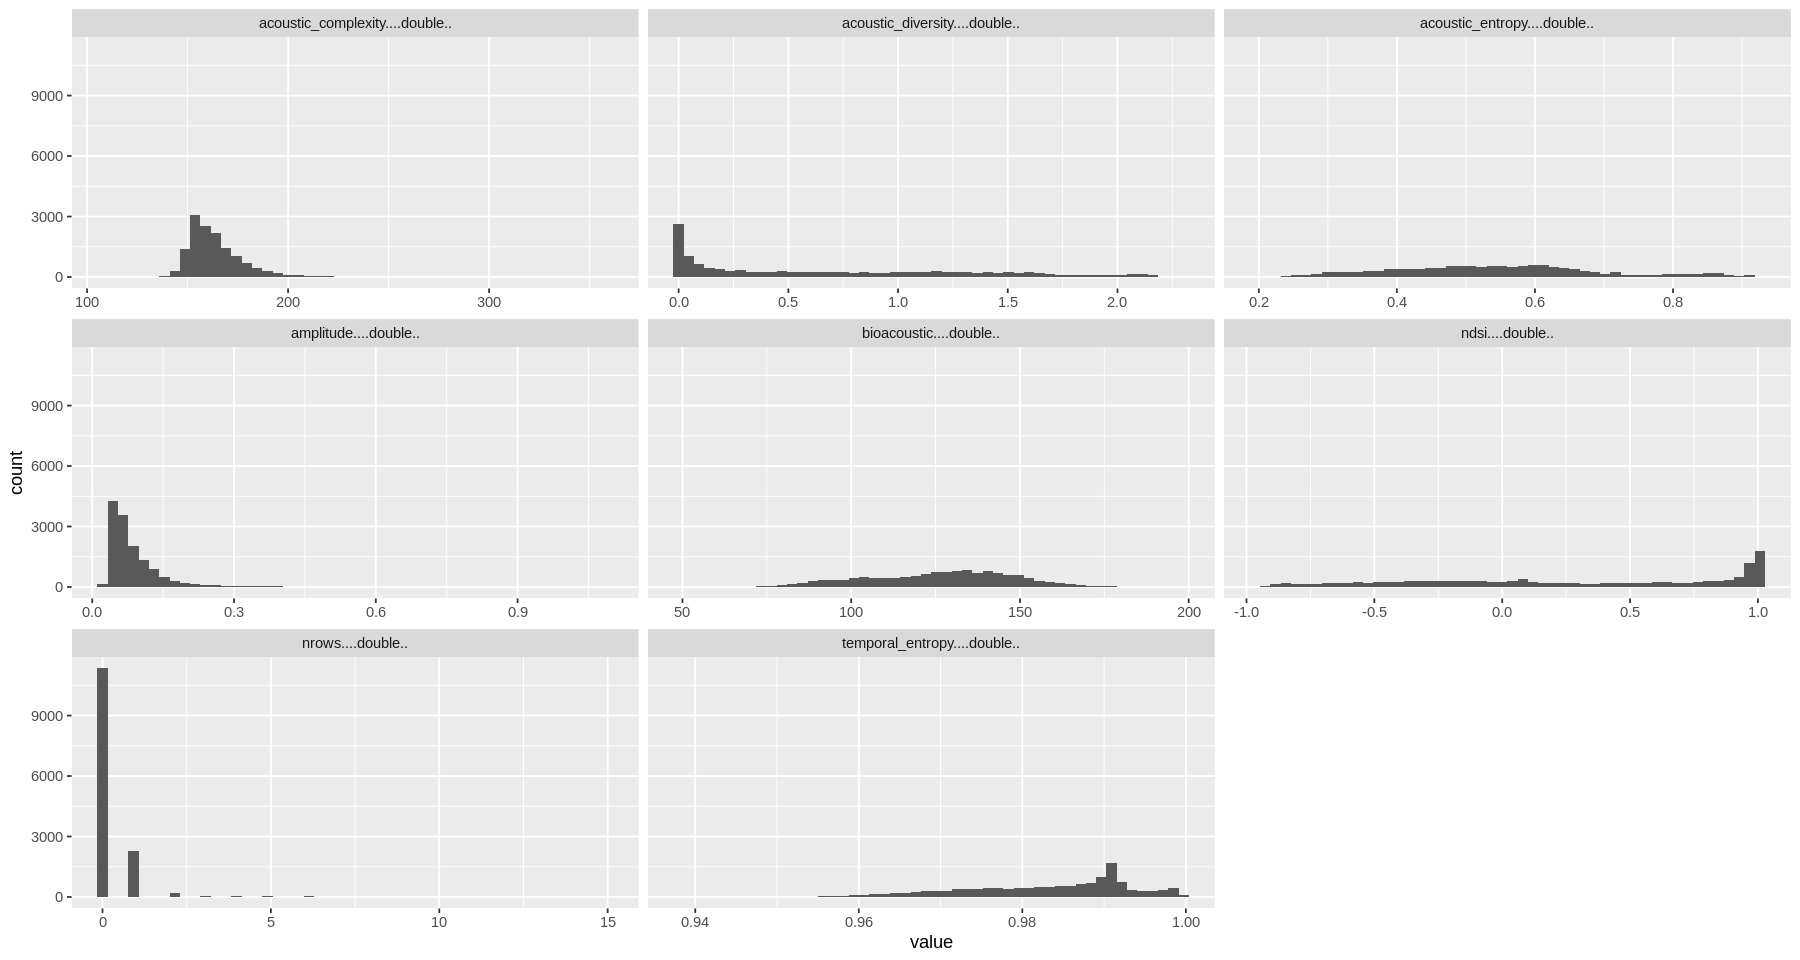

In [44]:
ggplot(gather(index_data[,-(1:6)]), aes(value)) + 
    geom_histogram(bins = 50) + 
    facet_wrap(~key, scales = 'free_x')

Basic Summarization Statistics are given for each of the alpha indices.

In [45]:
summary(index_data)
#colnames(index_data)

            Site      Date....as.Date.character....format.....Y..m..d..
 Tumamoc_NA   :1827   2019-04-14:  542                                 
 Sweetwater_NA:1571   2018-09-07:  528                                 
 Saguaro_NP   :1522   2018-09-08:  528                                 
 Gates_Pass   :1379   2019-06-09:  528                                 
 Ruth_NA      :1231   2019-06-10:  528                                 
 Theresa_NA   :1197   2019-06-11:  528                                 
 (Other)      :5366   (Other)   :10911                                 
 Time....character..                           Name....character..
 15:0:0 :   54       Theresa_S4A07341_20180824_020000.wav:   12   
 15:10:0:   53       Theresa_S4A07341_20180824_060000.wav:   12   
 15:15:0:   53       Theresa_S4A07341_20180824_071000.wav:   12   
 15:5:0 :   53       Theresa_S4A07341_20180824_082000.wav:   12   
 2:0:0  :   53       Theresa_S4A07341_20180824_093000.wav:   12   
 2:10:0 :   53       T

## Clustering/PCA

First, we scale the data:

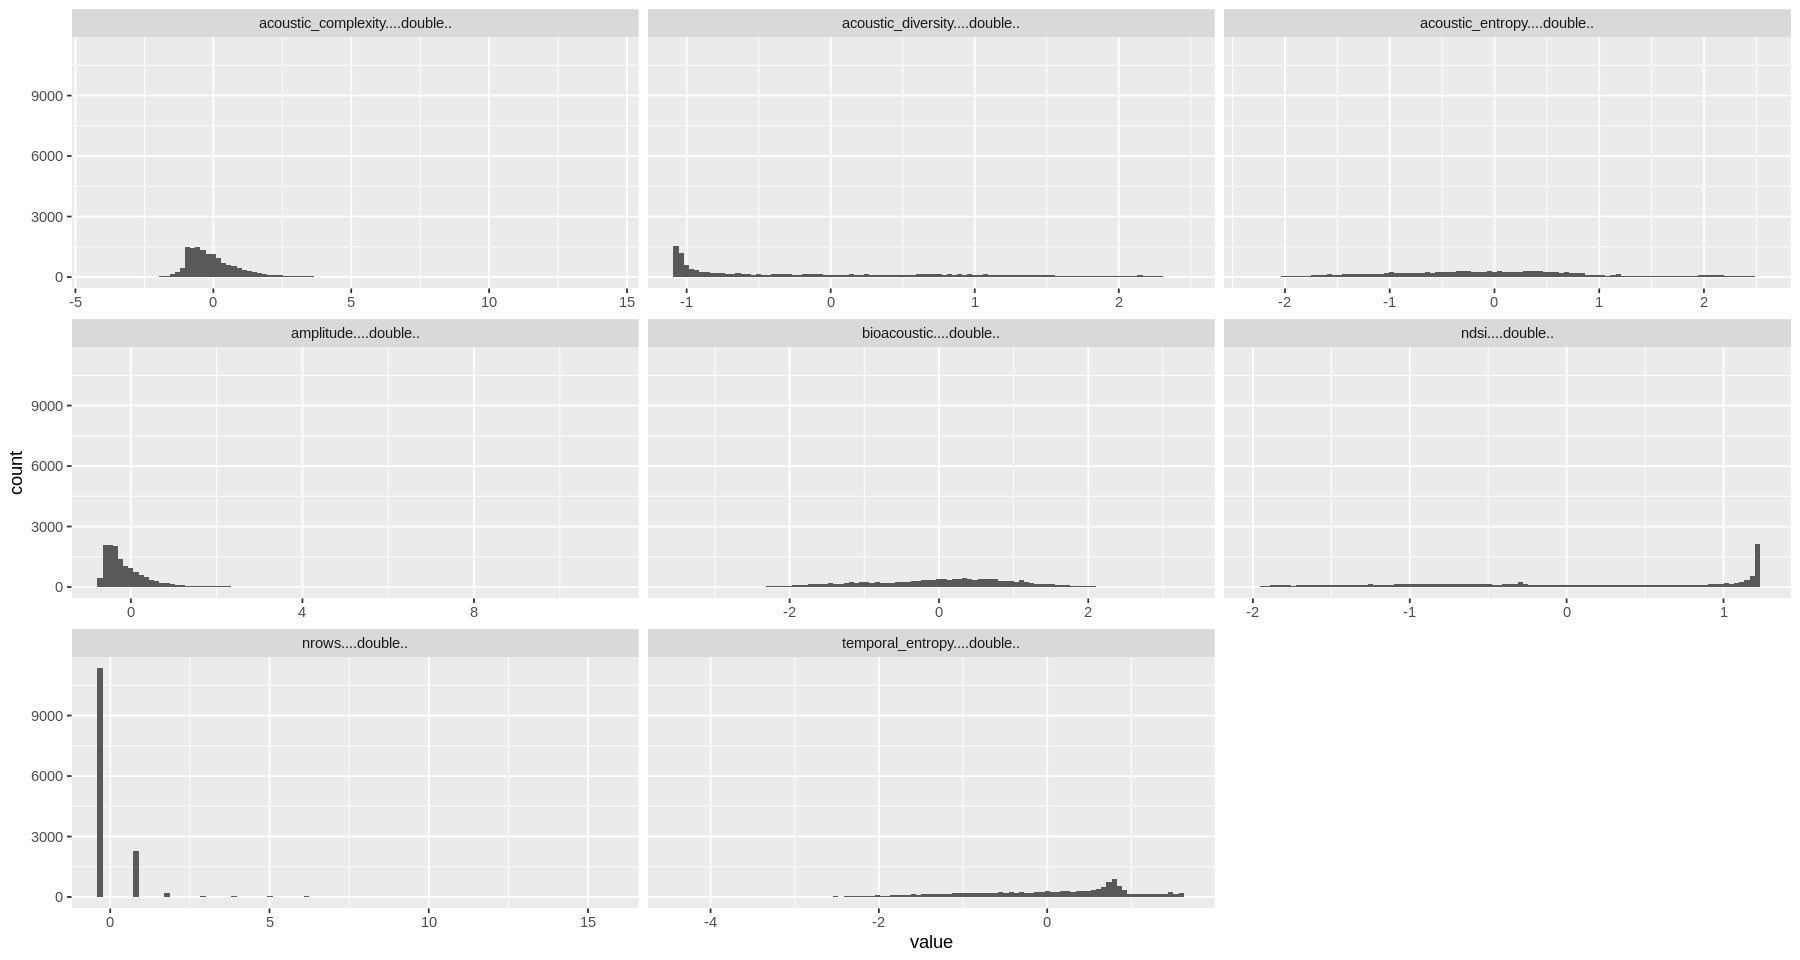

In [46]:
index_data[,-(1:6)] <- scale(index_data[,-(1:6)])
ggplot(gather(index_data[,-(1:6)]), aes(value)) + 
    geom_histogram(bins = 100) + 
    facet_wrap(~key, scales = 'free_x')


Using the average silhouette metric, we see that two is the most natural clustering, with a local maximum of average silhoutte at 10 clusters. 

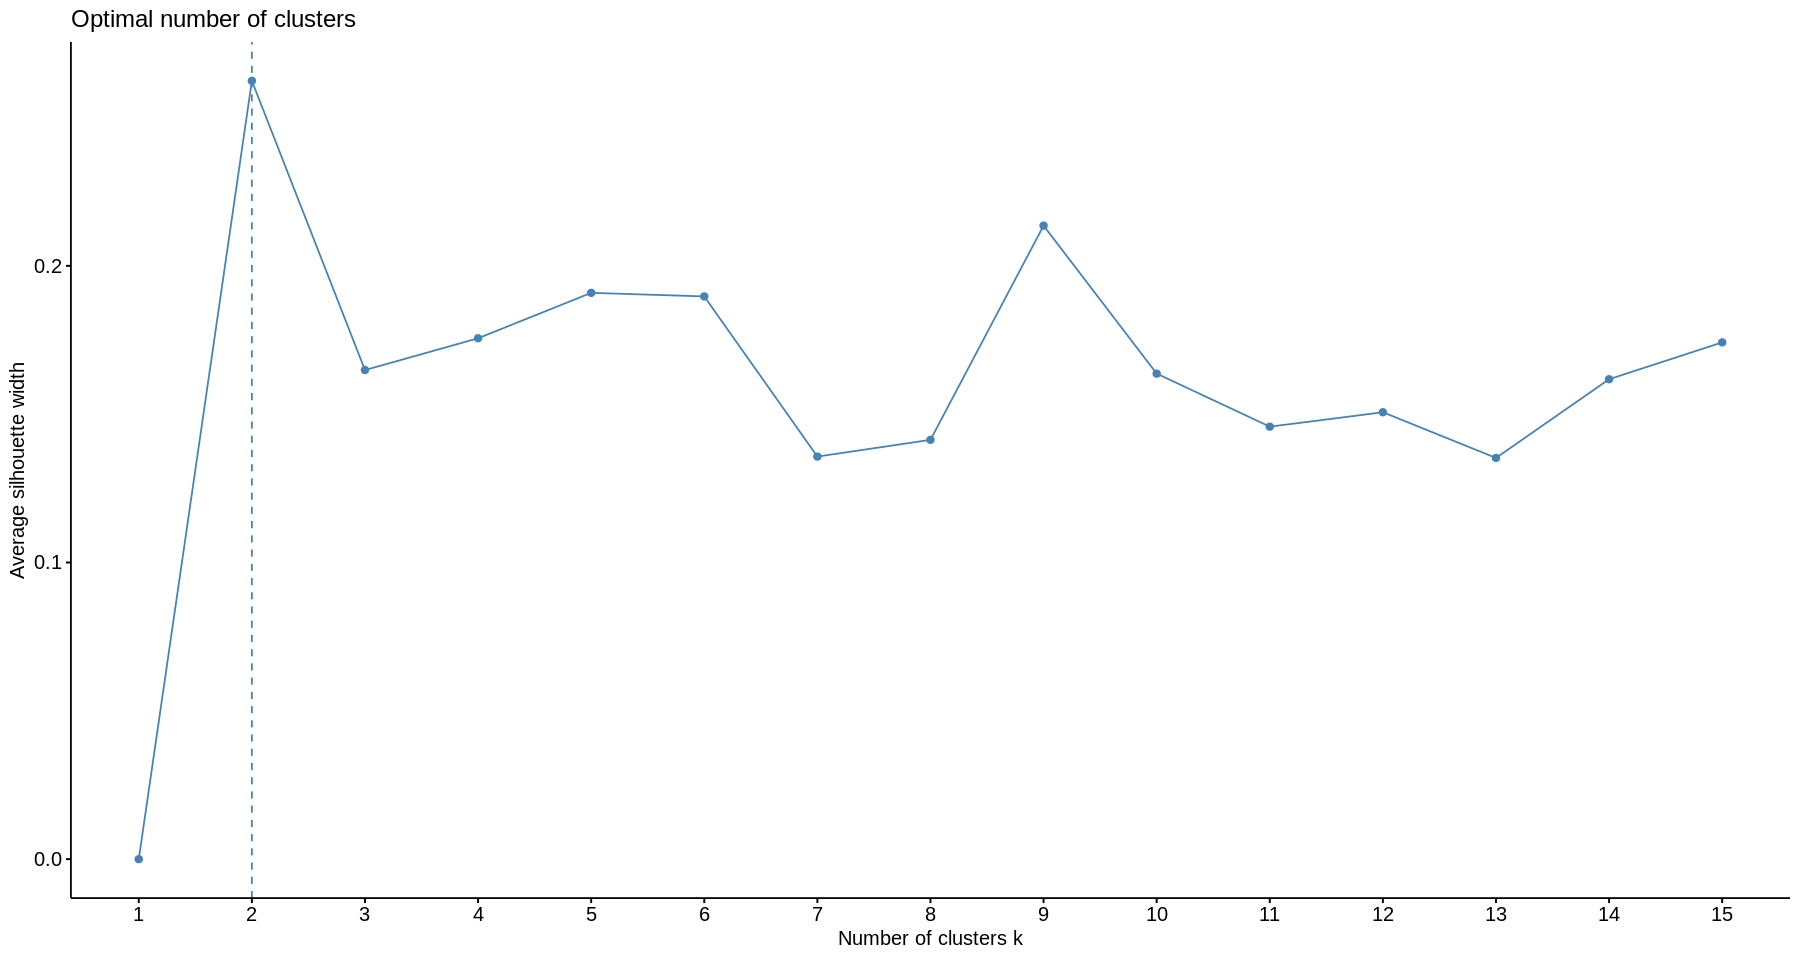

In [47]:
fviz_nbclust(index_data[,-(1:6)],FUNcluster=clara,method = "silhouette",k.max=15,verbose=TRUE)

The cluster sizes and means of a clustering with 10 clusters are given below, along with a two-dimensional graph of the clusters with the two-dimensions given by the first two principal components:

A histogram indicating the frequency of the hour of the recording in each cluster given below(a histogram for every cluster).

In [48]:
file_adder <- function(name,start,end,dest_folder,site,date,time) {
    data_path <- "/media/colton/My Passport/data_library"
    file_directory <- list.files(data_path,recursive=TRUE,pattern=".wav")
    if (!dir.exists(dest_folder)) {
        dir.create(dest_folder)
    }
    for(i in 1:length(file_directory)){
        if (tail(unlist(strsplit(file_directory[i], "/")),n=1)==name)
        {
            name <- paste(site,date,paste(time,".wav",sep=''),sep="_")
            file <- paste(data_path,file_directory[i],sep="/")
            selection <- readWave(file,from=start,to=end,units='minutes')
            writeWave(selection, paste(dest_folder,name,sep="/"))
            }
    }
    
}

In [52]:
splitter <- function(x) {return(strsplit(x,":")[[1]][1])}
month_getter<- function(x) {return(as.numeric(strsplit(as.character(x),"-")[[1]][2]))}
'%notin%' <- Negate(`%in%`)
euclidean <- function(cluster,center,clust_num) {
    square_dist <- 0
    for (index in 1:8) {
        #print(as.numeric(as.character(cluster[,3+index])))
        #print(as.numeric(as.character(center[num_clusters,index])))
        square_dist <- square_dist + (as.numeric(as.character(cluster[,6+index]))-as.numeric(as.character(center[clust_num,index])))^2
    }
    return(sqrt(square_dist))
}
histogram_plotter <- function(fit,data) {
    sites<-unique(index_data$Site)
    times<-c(0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23)
    months<-c(1,2,3,4,5,6,7,8,9,10,11,12)
    total_site_counts <- data %>% 
             count(vars = c("Site")) 
    dest_folder<-paste("clustering",as.character(length(fit$size)),"centers",sep='_')
for (i in 1:length(fit$size)){
    cluster <- subset(data, fit.cluster==as.character(i))
    cluster
    cluster$hr <- sapply(as.character(cluster$Time....character..),splitter)
    cluster$month <- sapply(cluster$Date....as.Date.character....format.....Y..m..d..,month_getter)
    time_counts <- cluster %>% 
                count(vars = c("hr"))
    for (time in times){
        if (time %notin% unique(time_counts$hr)){
            time_counts<-rbind(time_counts,c(time,0))
        }        
    }
    
    time_counts = mutate(time_counts,hr=factor(hr, levels=times))
    month_counts <- cluster %>% 
            count(vars = c("month"))
    for (month in months){
        if (month %notin% unique(month_counts$month)){
            time_counts<-rbind(time_counts,c(time,0))
        }        
    }
    
    month_counts = mutate(month_counts,month=factor(month, levels=months))
    site_counts <- cluster %>% 
                count(vars = c("Site")) 
    for (site in sites){
        if (site %notin% unique(site_counts$Site)){
            site_counts<-rbind(site_counts,c(site,0))
        }        
    }
    site_counts <- merge(site_counts,total_site_counts,by="Site")
    #site_counts <- site_counts %>% mutate(percent=site_counts[freq.x/freq.y)
    
    site_counts <- transform(site_counts, percent = as.numeric(freq.x) / as.numeric(freq.y))
    cluster <- mutate(cluster,dist=euclidean(cluster,fit$centers,i))
    closest <- cluster[which.min(cluster$dist), ]
    
    if (strsplit(as.character(closest$Site[1]),"_")[[1]][2]=="NA") {
        site <- strsplit(as.character(closest$Site[1]),"_")[[1]][1]
    }
    else {
        site <-as.character(closest$Site[1])
    }
    name <-as.character(closest$Name....character..[1]) 
    split_name <- tail(unlist(strsplit(name, "_")),n=3)
    whole_name <- as.character(paste(split_name[1],split_name[2],split_name[3],sep="_"))
    start<- as.numeric(closest$File_Start_Time....character..[1])
    end<- as.numeric(closest$File_End_Time....character..[1])
    date <- as.character(closest$Date....as.Date.character....format.....Y..m..d..[1])
    time <- as.character(closest$Time....character..[1]) 
    
    time_plot<-ggplot(time_counts) + geom_bar(aes(x = hr, y = freq), stat="identity") + ggtitle(paste("Time Frequency of Cluster with Center Closest to",site,date,time))+theme(axis.text.x = element_text(face = "bold", color = "#993333", 
                           size = 12, angle = 90))
    site_plot<-ggplot(site_counts) + geom_bar(aes(x = Site, y = as.numeric(as.character(freq.x)) ), stat="identity") + ggtitle(paste("Site Frequency of Cluster with Center Closest to",site,date,time))+theme(axis.text.x = element_text(face = "bold", color = "#993333", 
                           size = 12, angle = 90))
    percent_plot<-ggplot(site_counts) + geom_bar(aes(x = Site, y = percent), stat="identity") + ggtitle(paste("Percentage of Site Recordings within Cluster with Center Closest to",site,date,time))+theme(axis.text.x = element_text(face = "bold", color = "#993333", 
                           size = 12, angle = 90)) + ylim(0, 1)
    month_plot<-ggplot(month_counts) + geom_bar(aes(x = month, y = freq), stat="identity") + ggtitle(paste("Month Frequency of Cluster with Center Closest to",site,date,time))+theme(axis.text.x = element_text(face = "bold", color = "#993333", 
                           size = 12, angle = 90))
    #file_adder(whole_name,start,end,dest_folder,site,date,time)
    print(plot_grid(time_plot, site_plot,percent_plot,month_plot))
}
    
    }



[1]  198 3425  871 1543 2936 1527  988 2336  269

bioacoustic....double.. amplitude....double.. temporal_entropy....double..
1 -1.2705198               0.64263252           -0.1146382                  
2  0.4052994              -0.11015385            0.2316762                  
3 -0.8733948              -0.02741947           -0.8745066                  
4  0.9454933              -0.34890903            0.6912416                  
5 -0.1347080               0.20304265           -1.2962820                  
6 -1.1971618              -0.54163608            0.9481534                  
7 -1.1588903               0.33421311           -0.1455586                  
8  0.7191655              -0.31321054            0.5936318                  
9 -0.5434016               5.37058373            0.1466852                  
  acoustic_entropy....double.. acoustic_diversity....double..
1  2.17696977                   1.8648469                    
2 -0.02192006                  -0.5565527                    
3  1.56303150                   1.6875913                    
4  0.28609695                   0.7409203                    
5 -0.97388532                  -0.8559227                    
6 -1.04826707                  -0.6984084                    
7  1.23195864                   1.1187113                    
8  0.60608401                   0.6742200                    
9 -1.23333874                  -0.6579359                    
  acoustic_complexity....double.. nrows....double.. ndsi....double..
1 -0.3226738                       6.710862180       1.09717760     
2 -0.3944623                      -0.183367290      -1.06998540     
3  1.8225077                       0.002277056       1.03225437     
4  1.0057635                      -0.139877109       0.58820122     
5  0.3296754                      -0.292669452      -0.36994921     
6 -0.6052543                      -0.211454690      -0.08190909     
7 -0.8287789                       0.341653519       1.14038939     
8 -0.6016628                       0.186993287       0.78606794     
9  1.6960586                      -0.293947405      -0.41242597

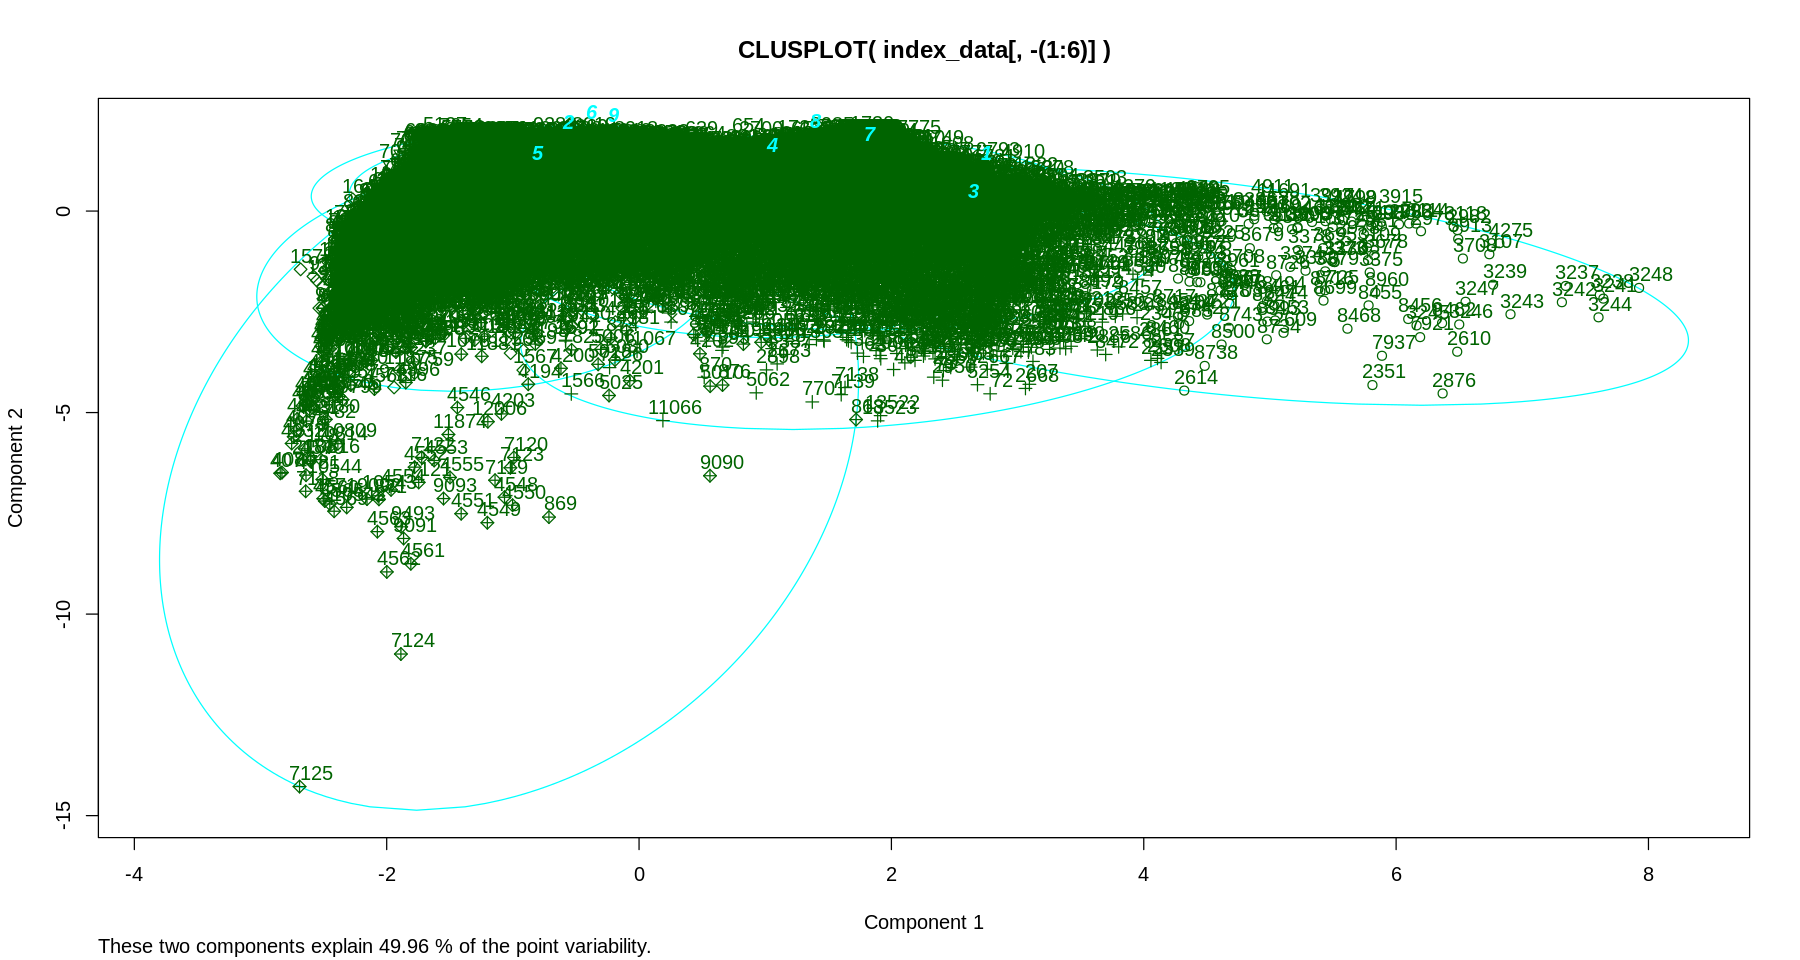

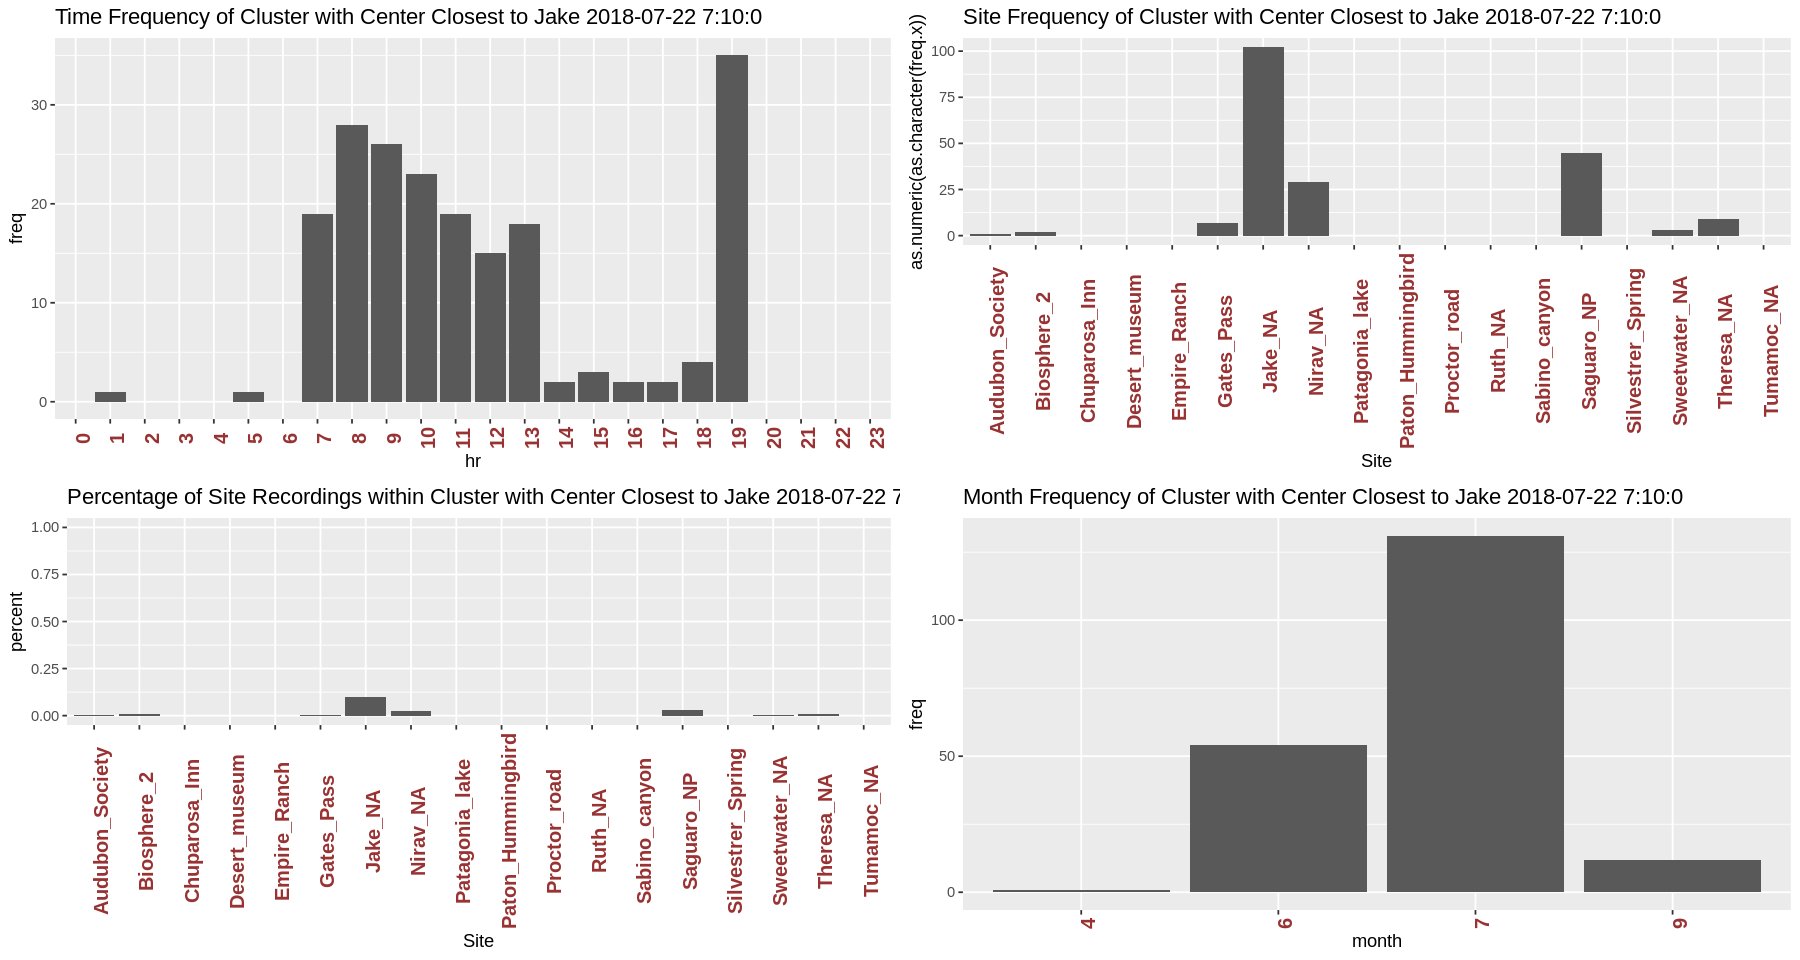

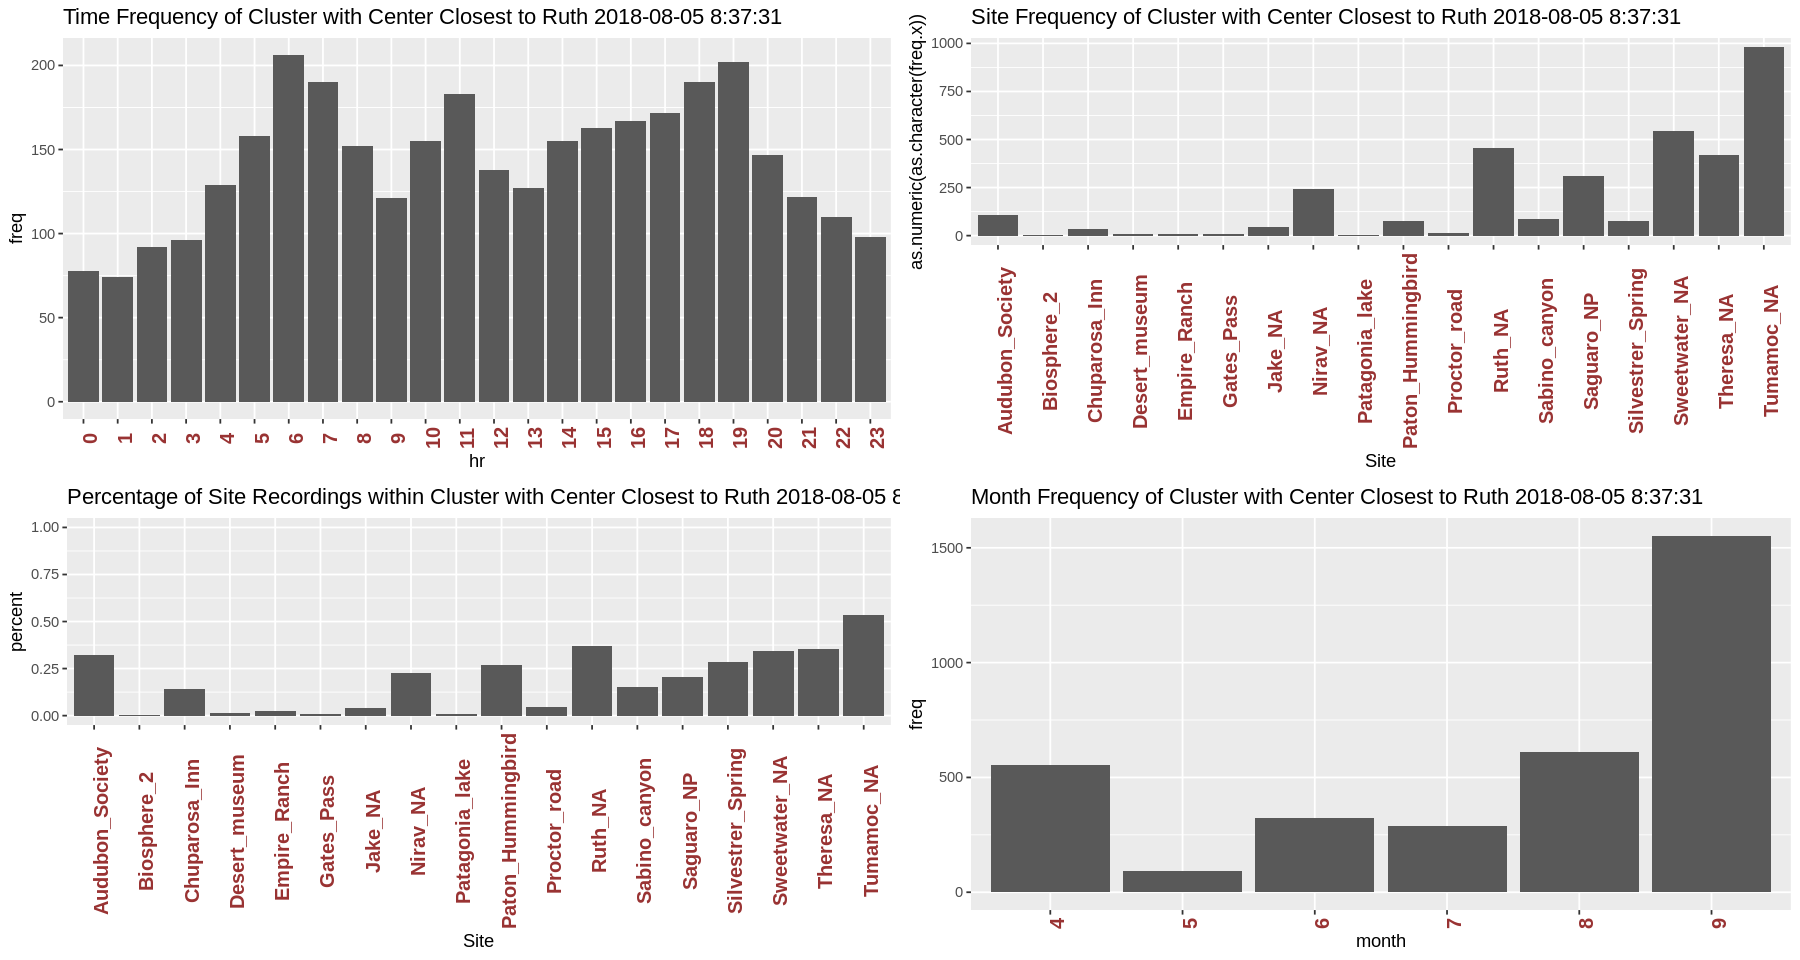

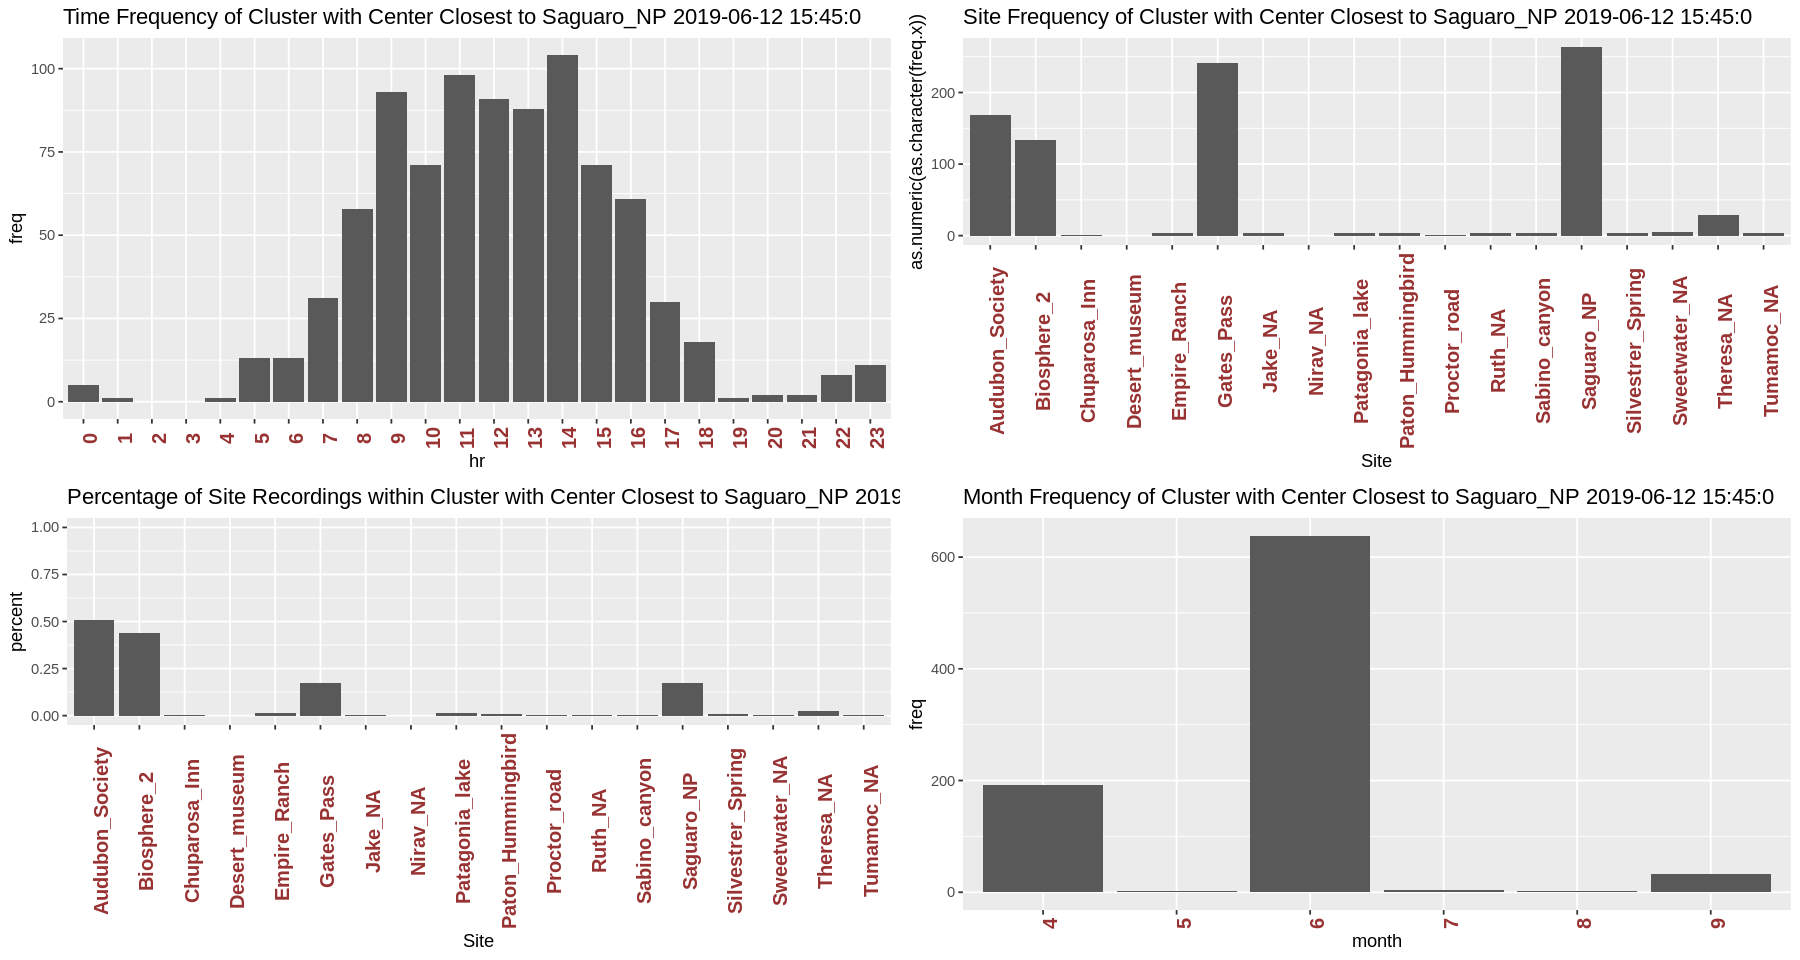

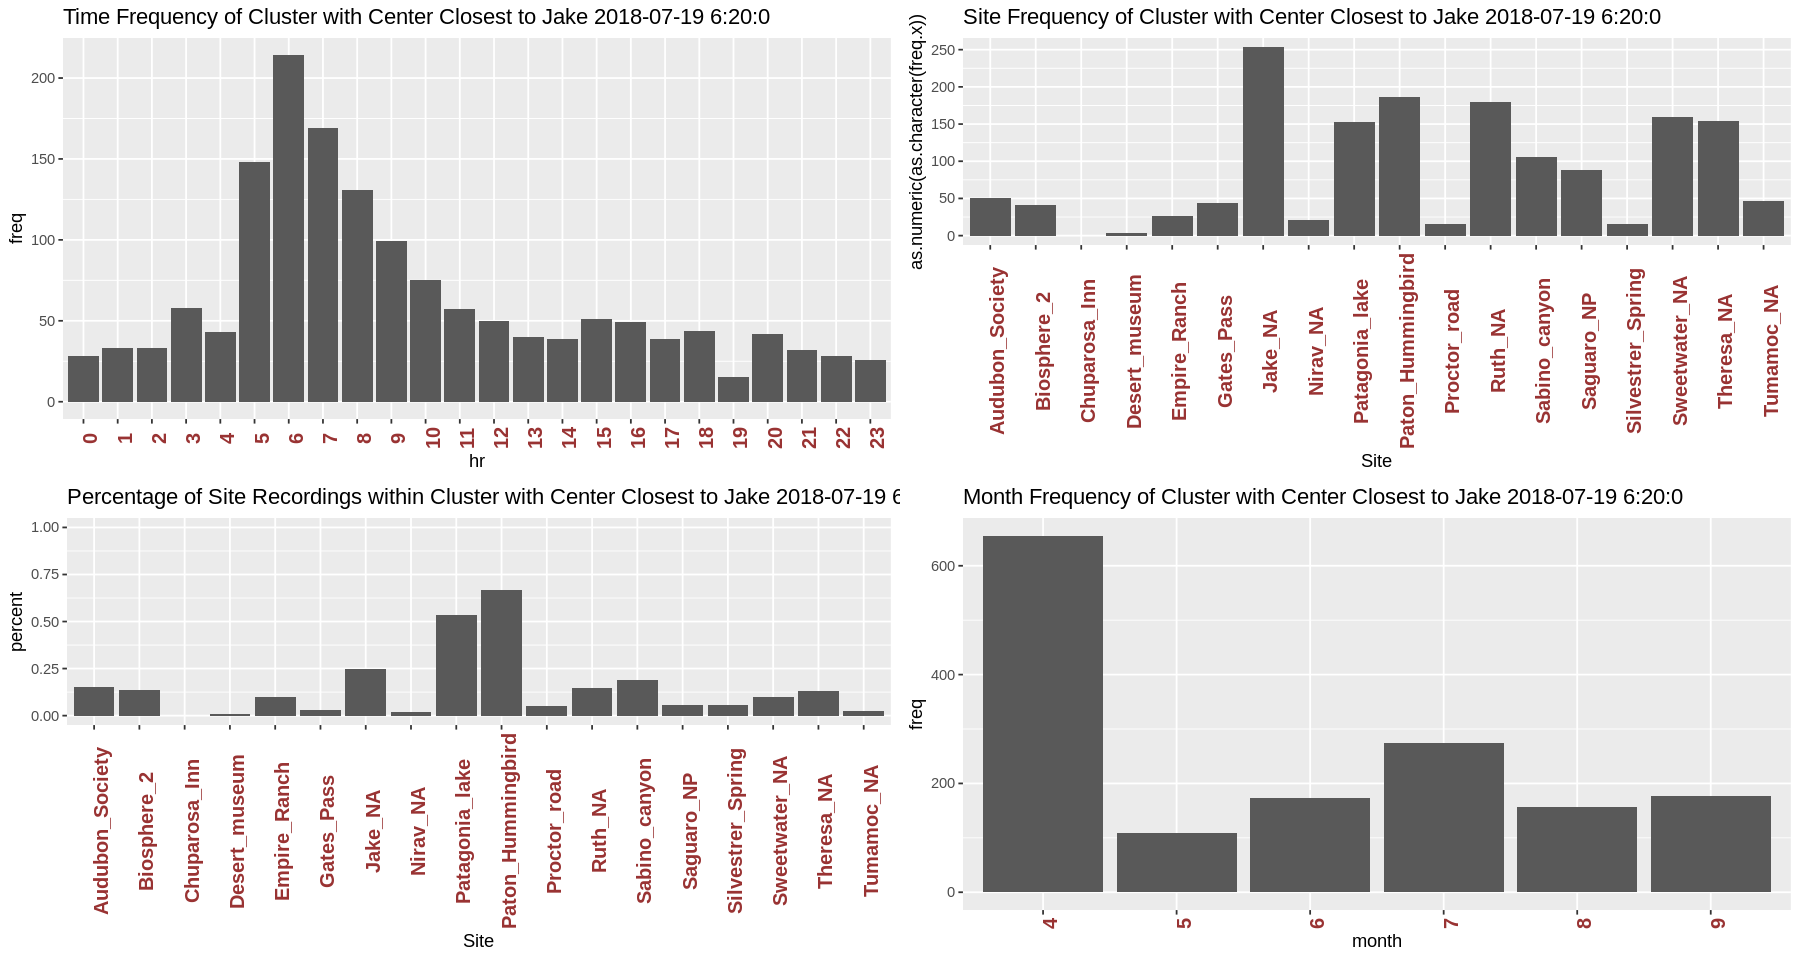

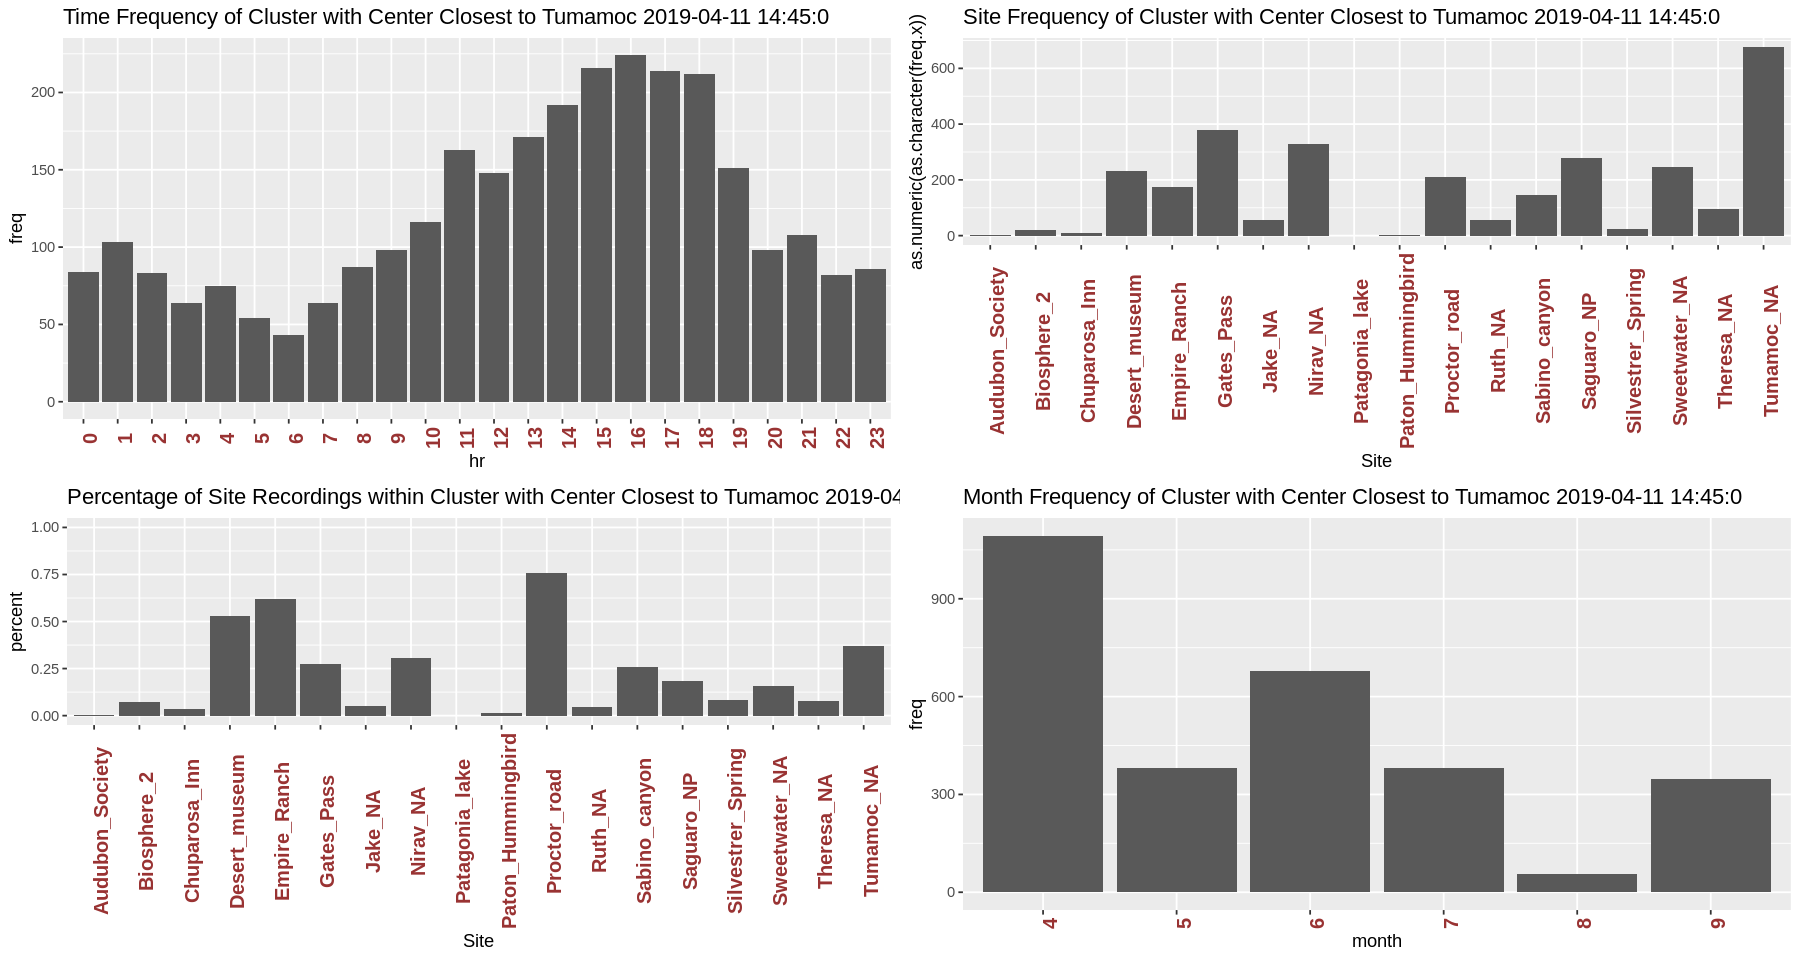

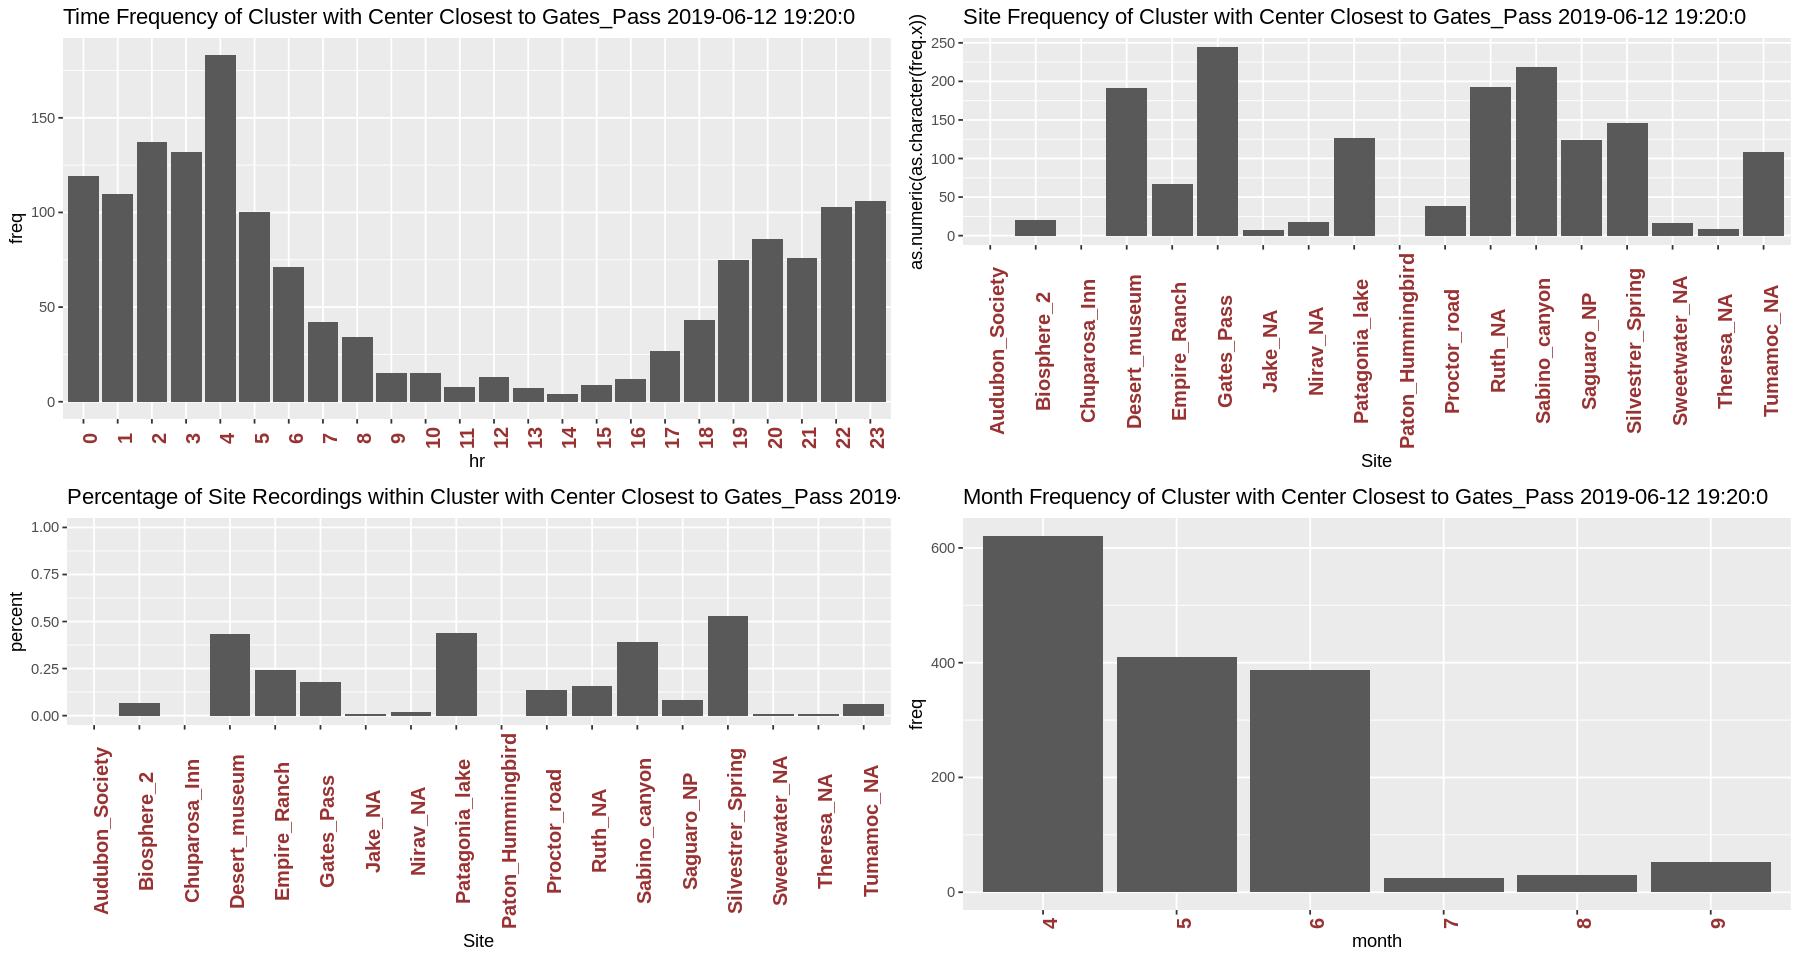

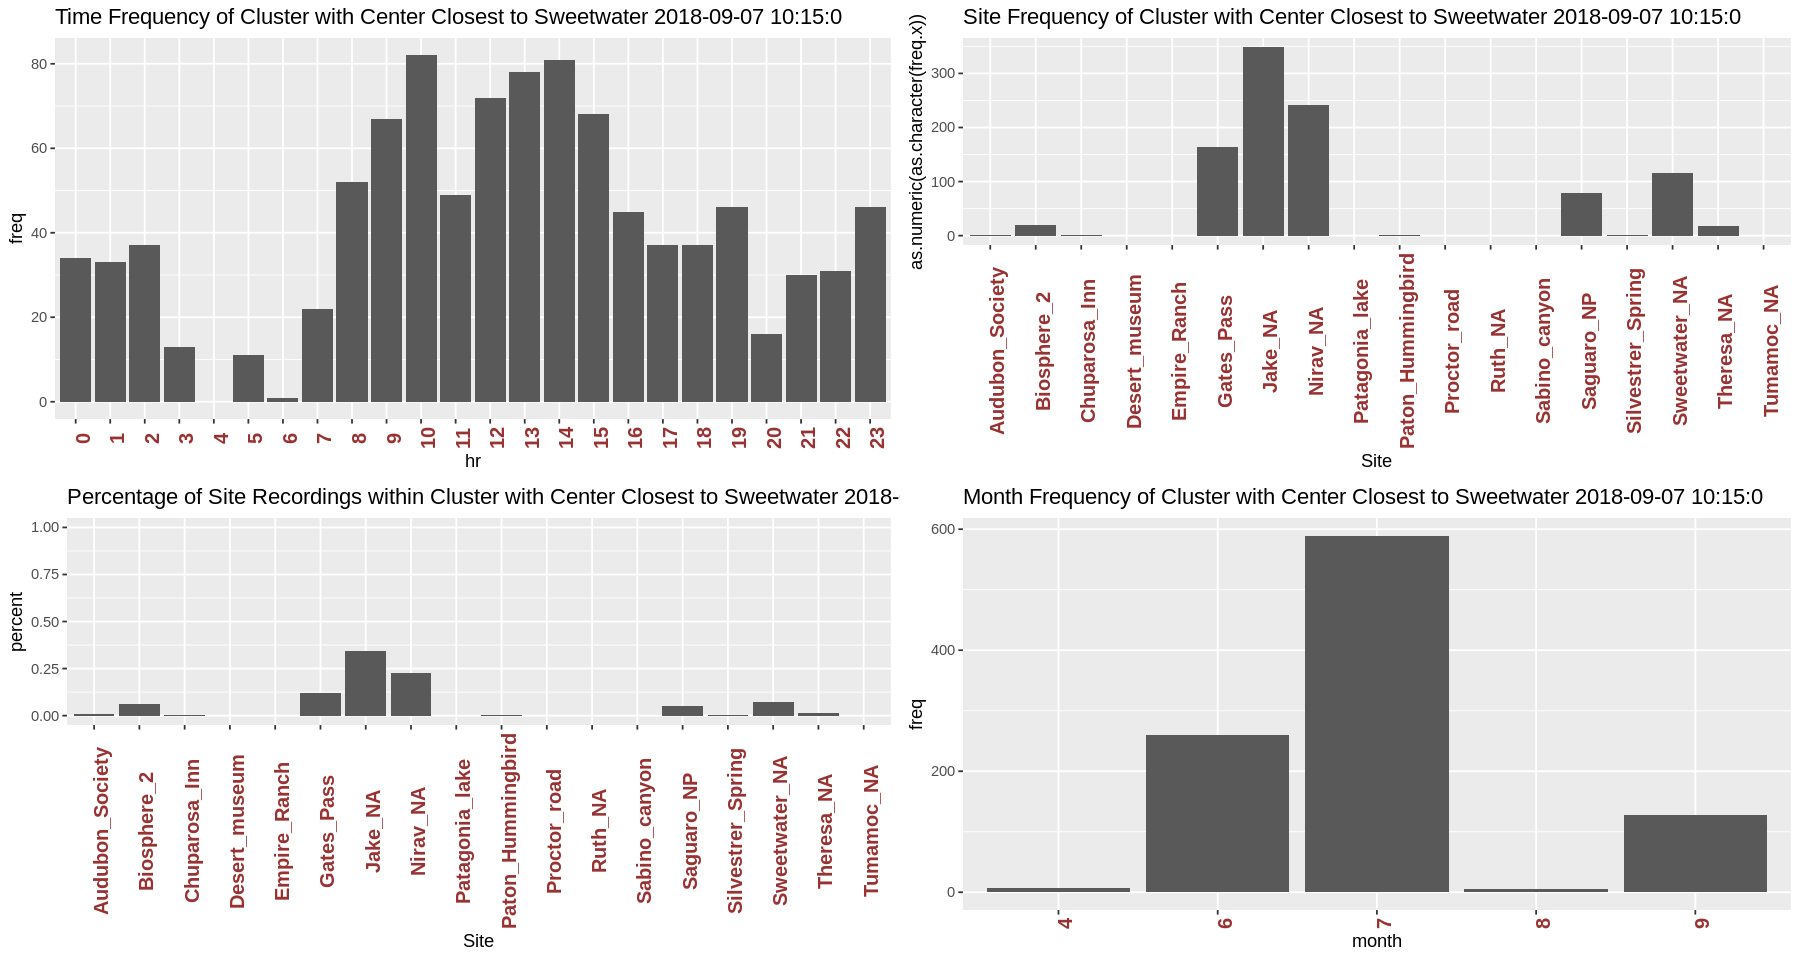

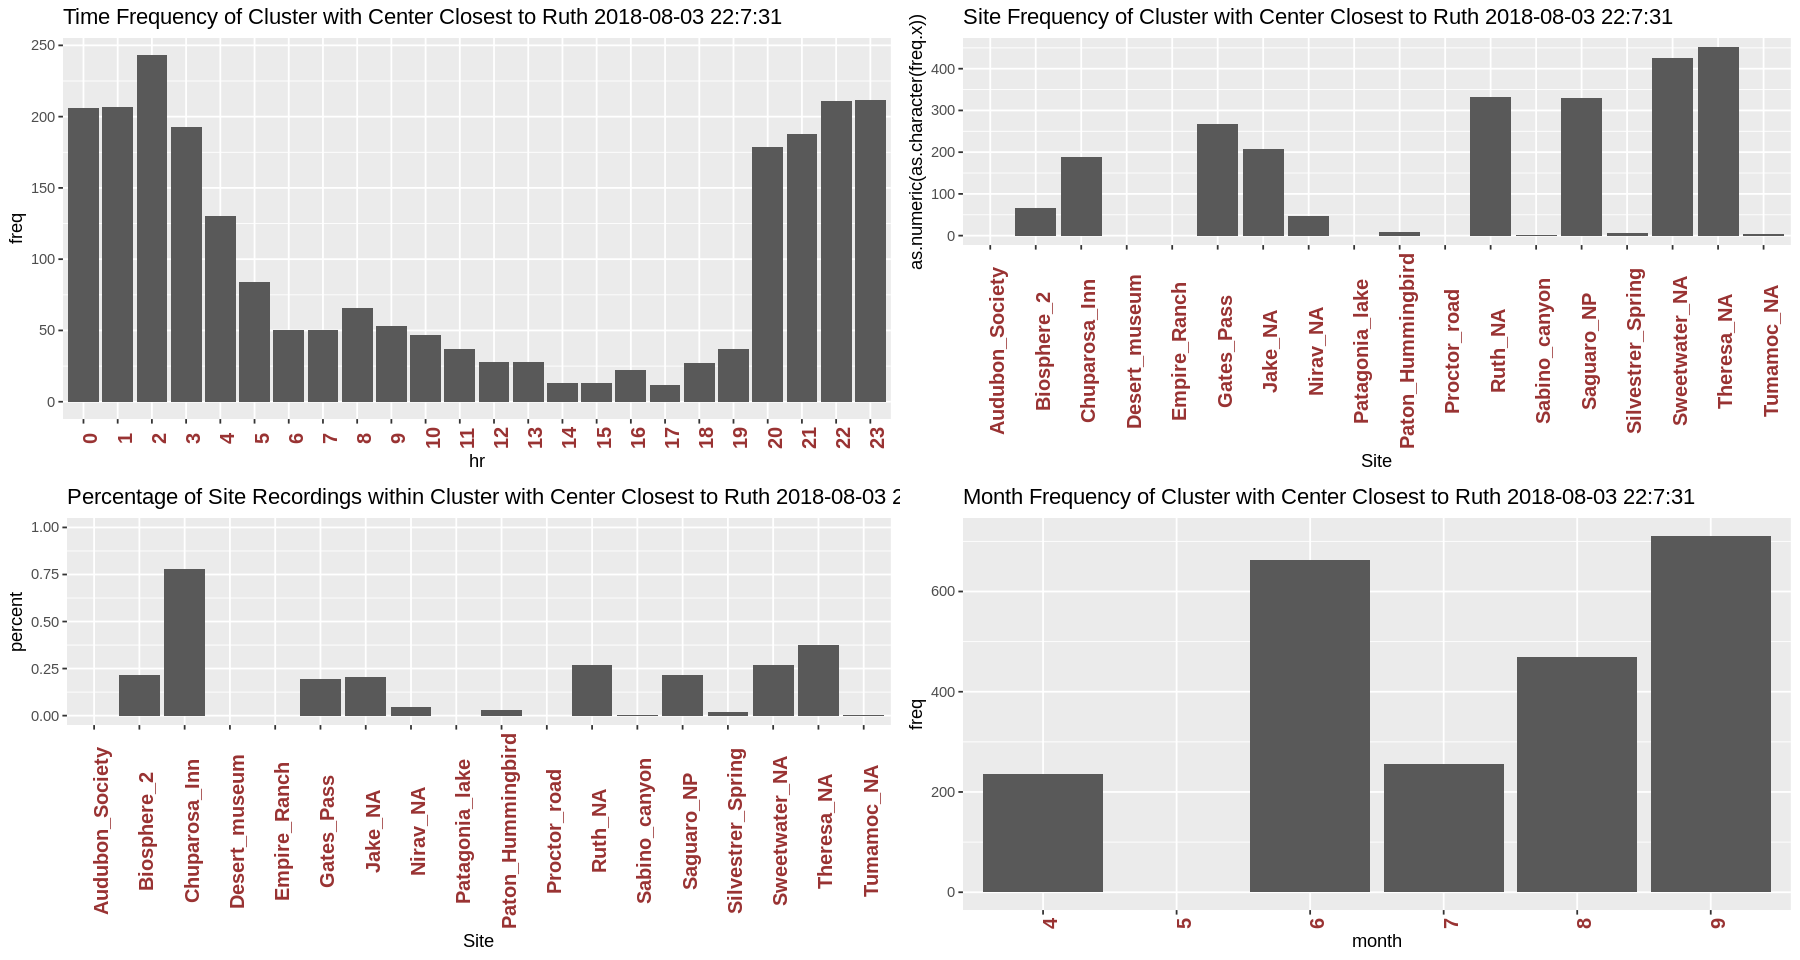

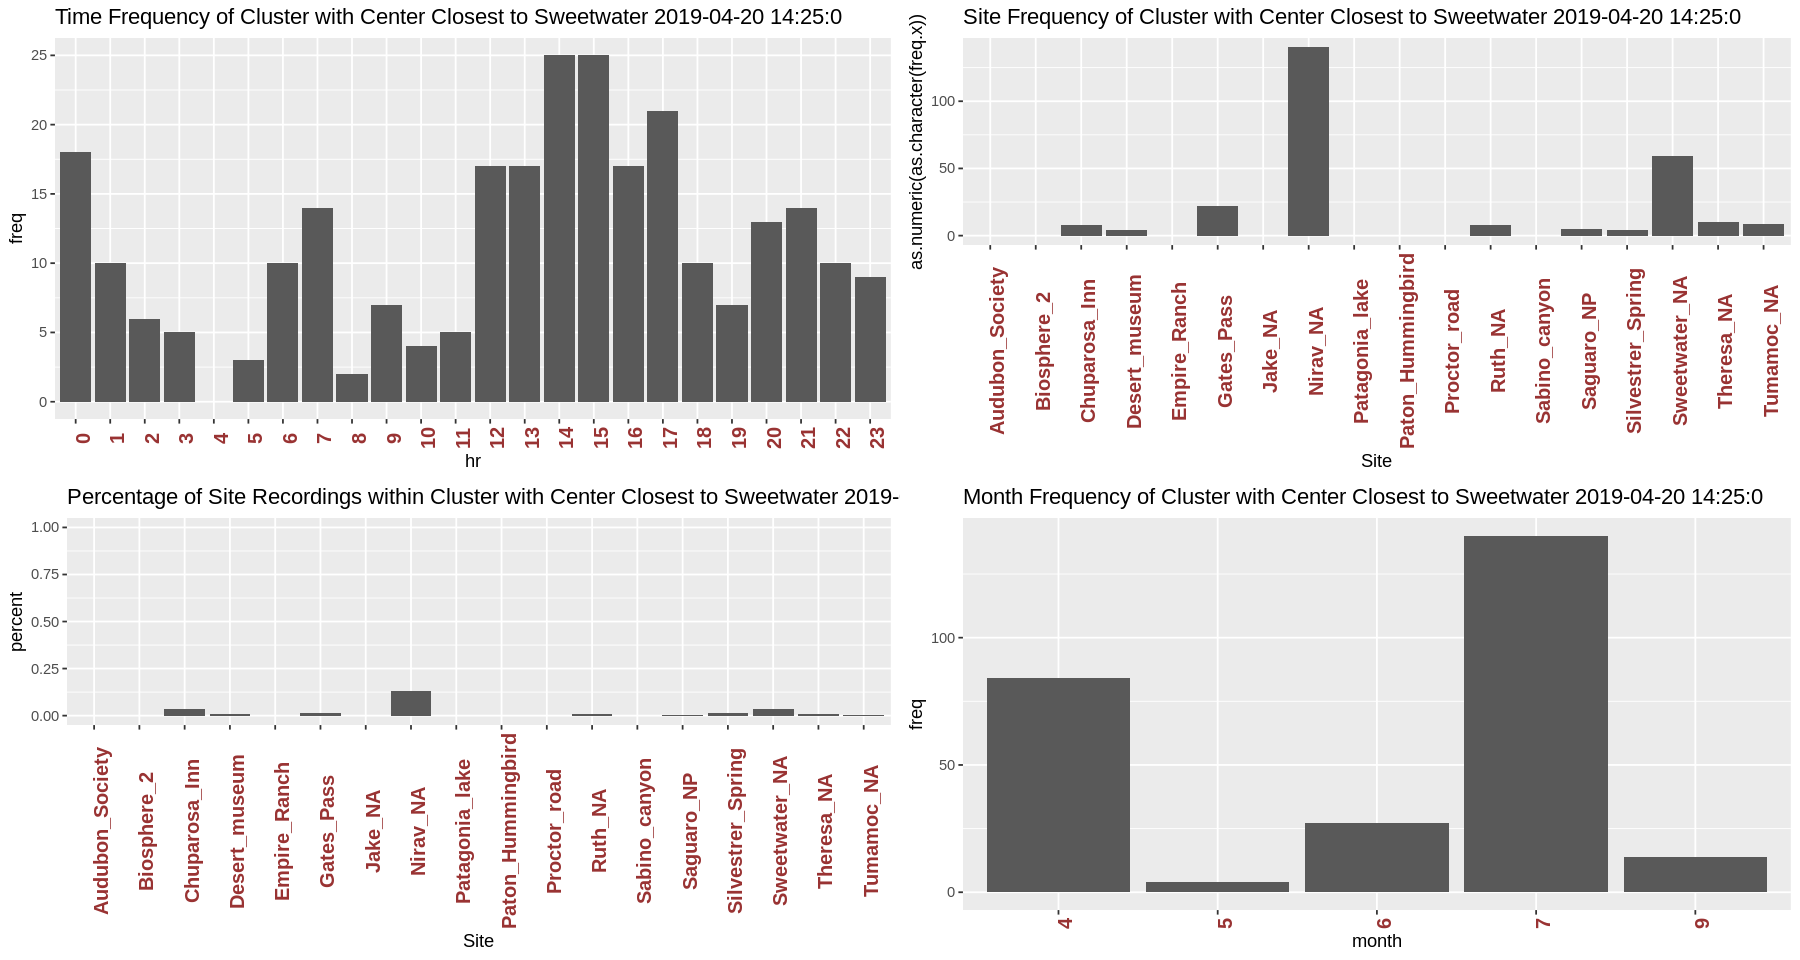

In [73]:
# K-Means Clustering with 10 clusters

fit <- kmeans(index_data[,-(1:6)],9,iter.max=30)
fit$size
fit$centers
# Cluster Plot against 1st 2 principal components

# vary parameters for most readable graph
clusplot(index_data[,-(1:6)], fit$cluster, color=FALSE, shade=FALSE,
   labels=2, lines=0)

histogram_plotter(fit,data.frame(index_data, fit$cluster))
unscaled_index_data <- read.csv(INDEX_CSV,header=TRUE)
added_clust_one <- data.frame(unscaled_index_data, fit$cluster)

A histogram indicating the frequency of the site of the recording in each cluster given below(a histogram for every cluster).

[1]  798 1139  281  196  870 1869 1079 1744 1616  647 1431  437   88  851 1047

bioacoustic....double.. amplitude....double.. temporal_entropy....double..
1  -1.22821840              0.29972147           -0.008548476                
2  -1.27461132             -0.57725328            1.078124636                
3  -0.02495008              0.46417080           -0.011010124                
4  -1.26380672              0.65339123           -0.093169970                
5   0.24897910              0.02519749           -0.979470079                
6   0.78130497             -0.04018565            0.281744660                
7  -0.68084406             -0.05431269           -1.514841315                
8   0.61503504             -0.36217196            0.681114701                
9   0.16107227              0.09927200           -1.114867951                
10 -1.08249464             -0.22143497           -1.113140317                
11 -0.37945546             -0.30123219            0.485279332                
12 -0.13011100              2.80073011           -0.369654233                
13 -1.03728515              8.41423247            0.604380046                
14  0.87389327             -0.26236572            0.931156873                
15  1.01174302             -0.40492514            0.683604058                
   acoustic_entropy....double.. acoustic_diversity....double..
1   1.5160325                    1.2914020                    
2  -1.1143839                   -0.6981403                    
3   1.3130873                    1.4788390                    
4   2.1758842                    1.8614714                    
5  -0.1423398                   -0.1767924                    
6   0.1389737                   -0.5205493                    
7  -1.4143645                   -0.9257949                    
8   0.5888459                    0.6867557                    
9  -0.6749000                   -0.9134624                    
10  1.6191815                    1.7527168                    
11 -0.3687114                   -0.6727718                    
12 -1.1873254                   -0.7741247                    
13 -1.1228682                   -0.5442156                    
14  0.6342699                    0.9872543                    
15  0.2634652                    0.7288459                    
   acoustic_complexity....double.. nrows....double.. ndsi....double..
1  -0.85590452                      0.31663557        1.15443066     
2  -0.61835003                     -0.21931069        0.17284546     
3   3.15096777                      0.09652690        0.63693209     
4  -0.34610038                      6.73898904        1.09584595     
5  -0.13297104                     -0.04277789        0.84825356     
6  -0.35752958                     -0.17433479       -0.87491480     
7   0.61423316                     -0.31084112       -0.09760431     
8  -0.59179044                      0.30260531        1.00437421     
9  -0.01444509                     -0.29397689       -0.98353903     
10  1.35748388                     -0.03713870        1.15483339     
11 -0.52785906                     -0.17894597       -1.26673100     
12  0.87999214                     -0.29821768       -0.25800727     
13  2.81375551                     -0.25708542       -0.64895946     
14 -0.22533739                     -0.16841879       -0.37344849     
15  1.12986756                     -0.12293001        0.84205103

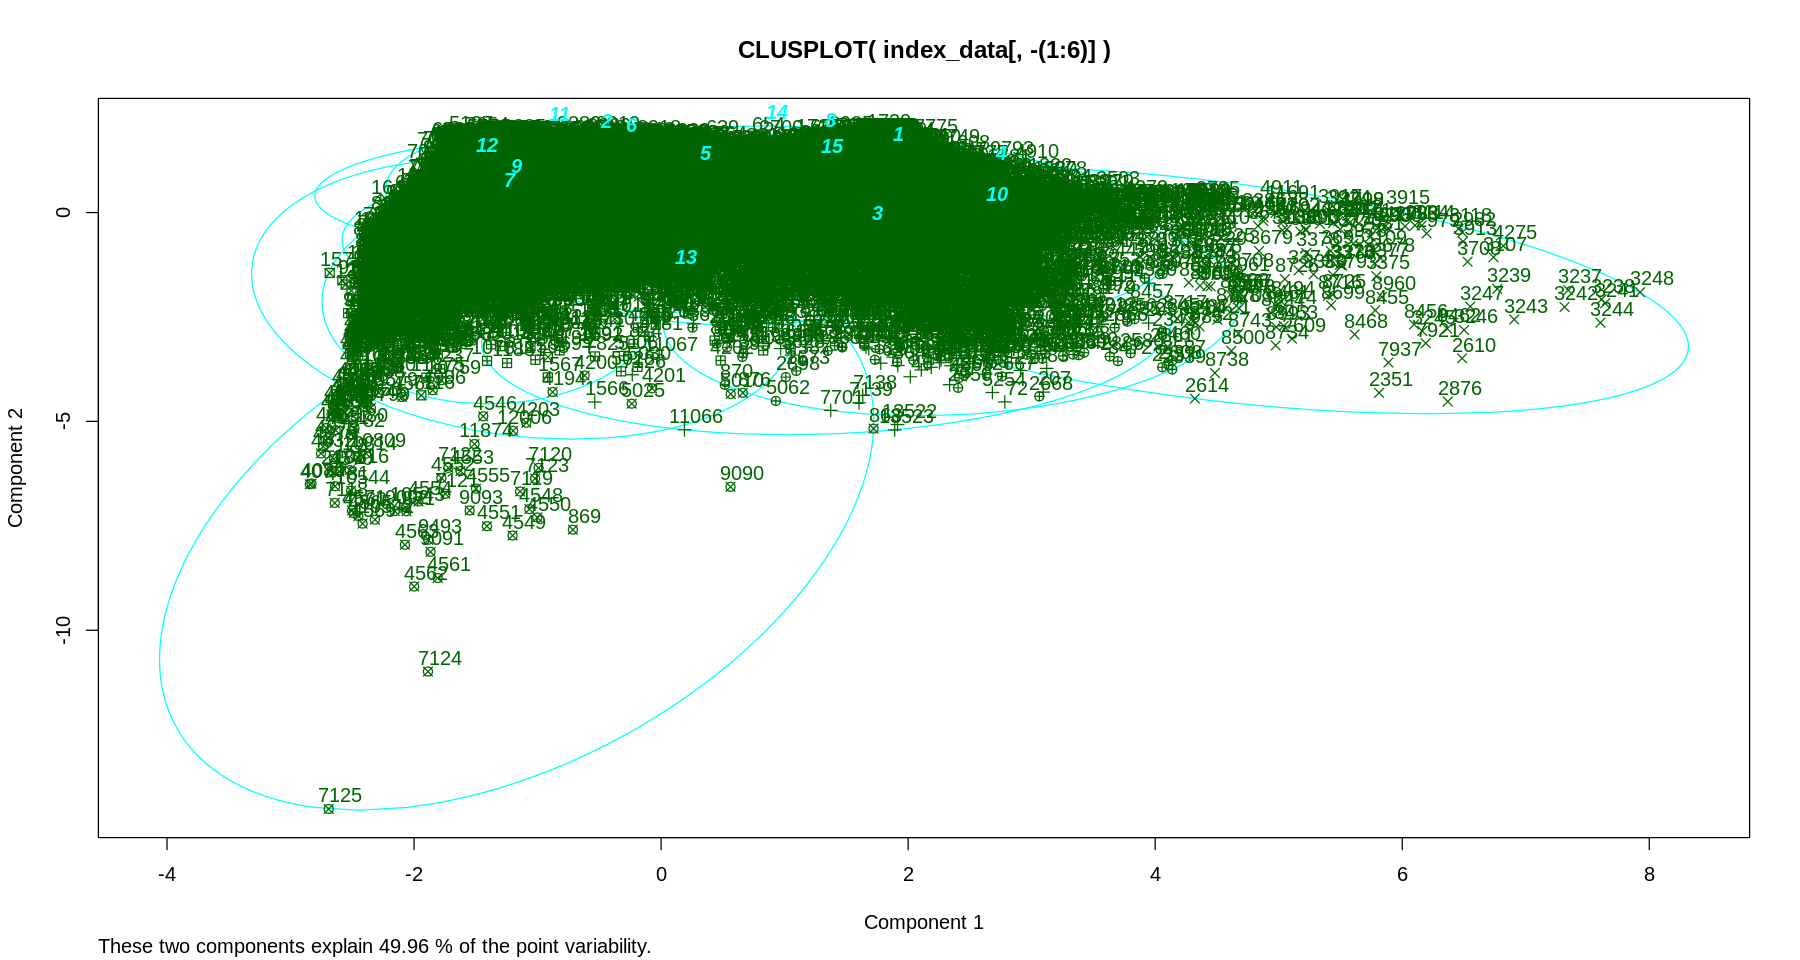

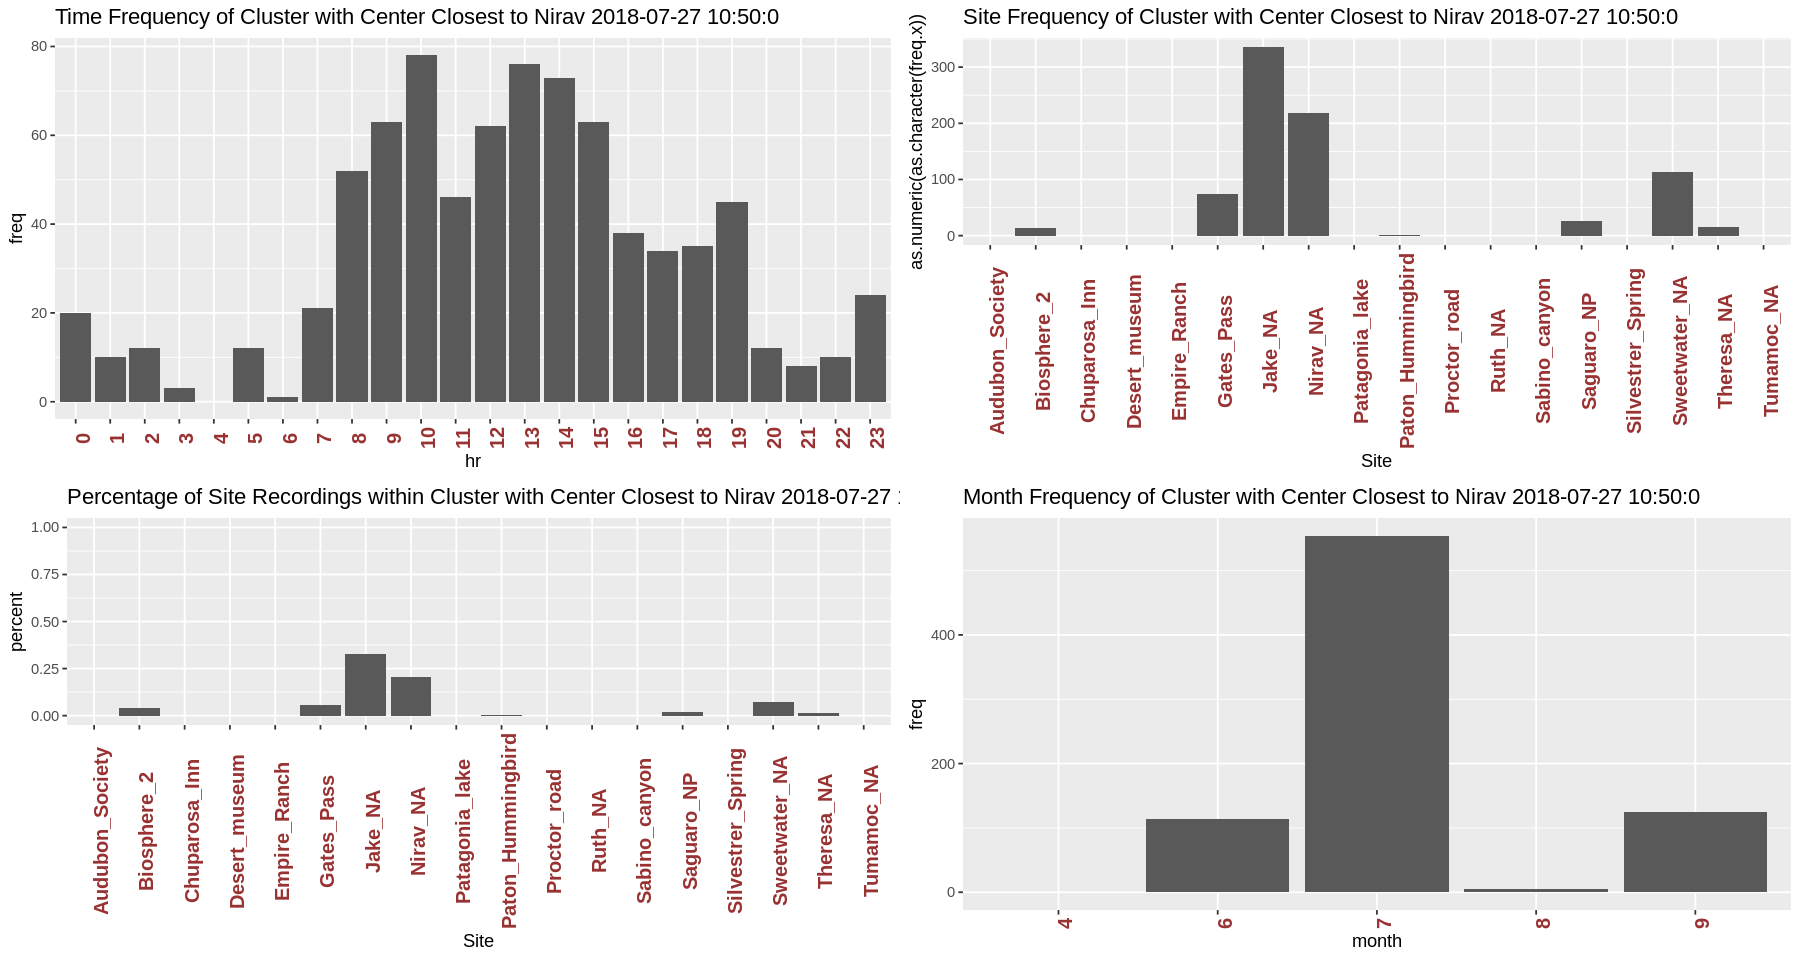

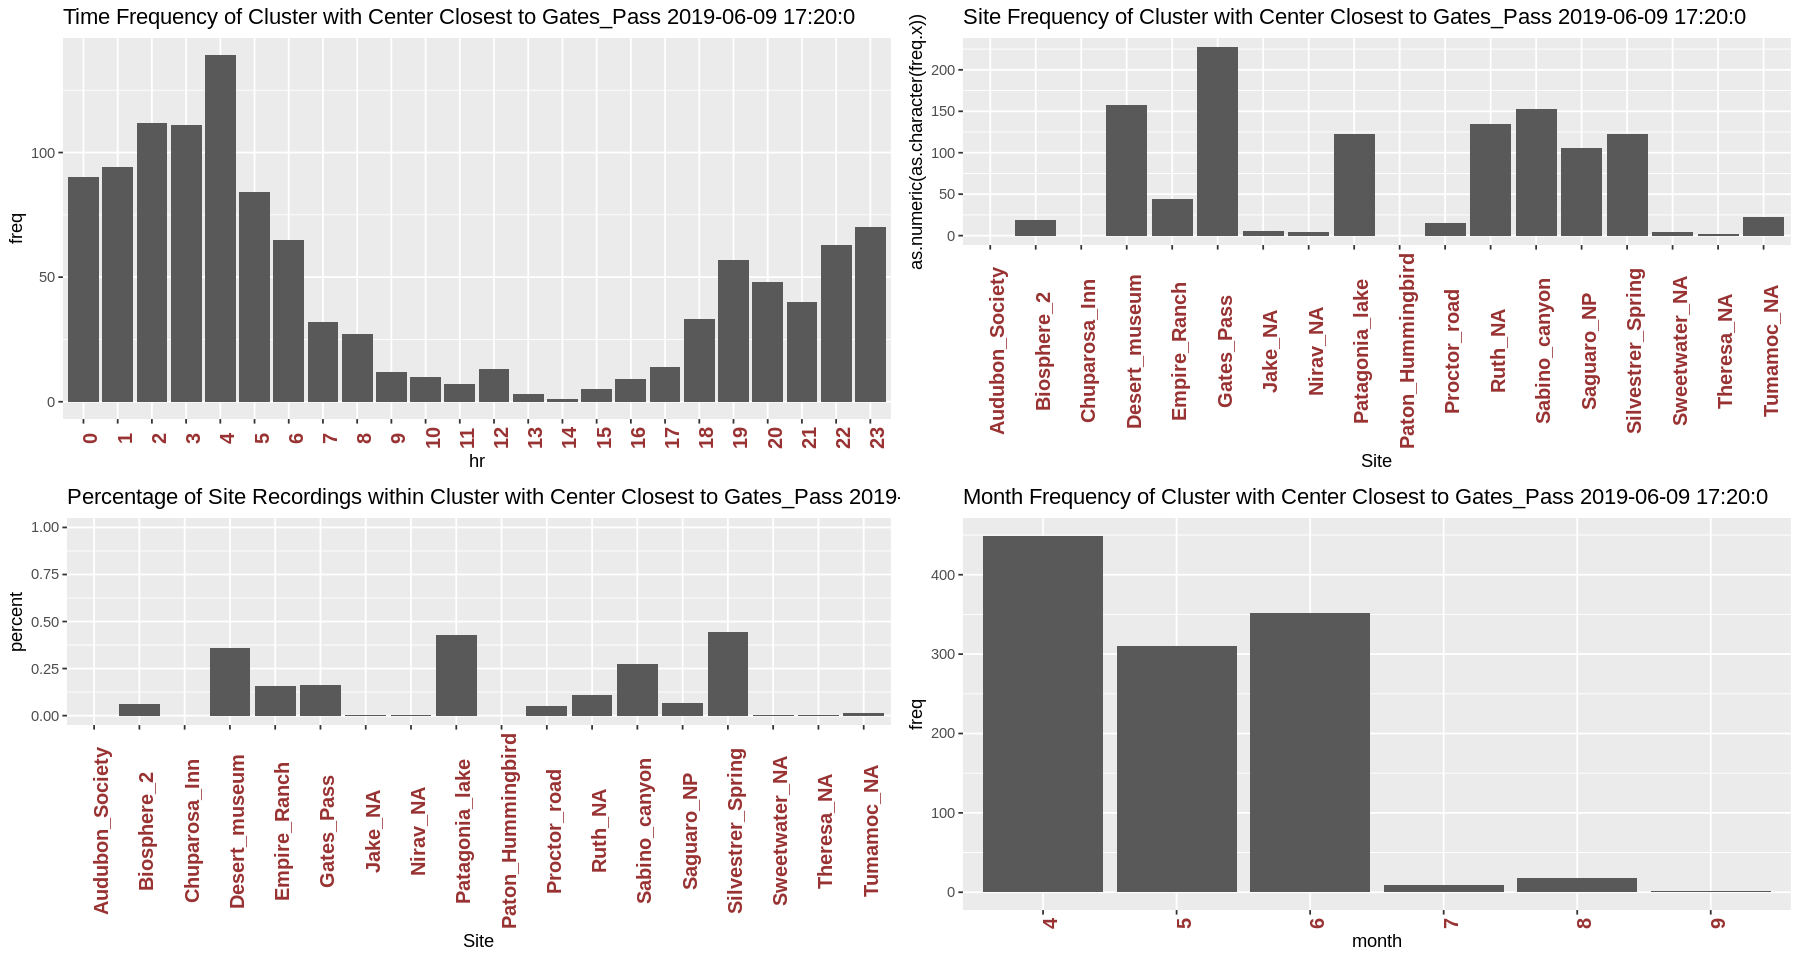

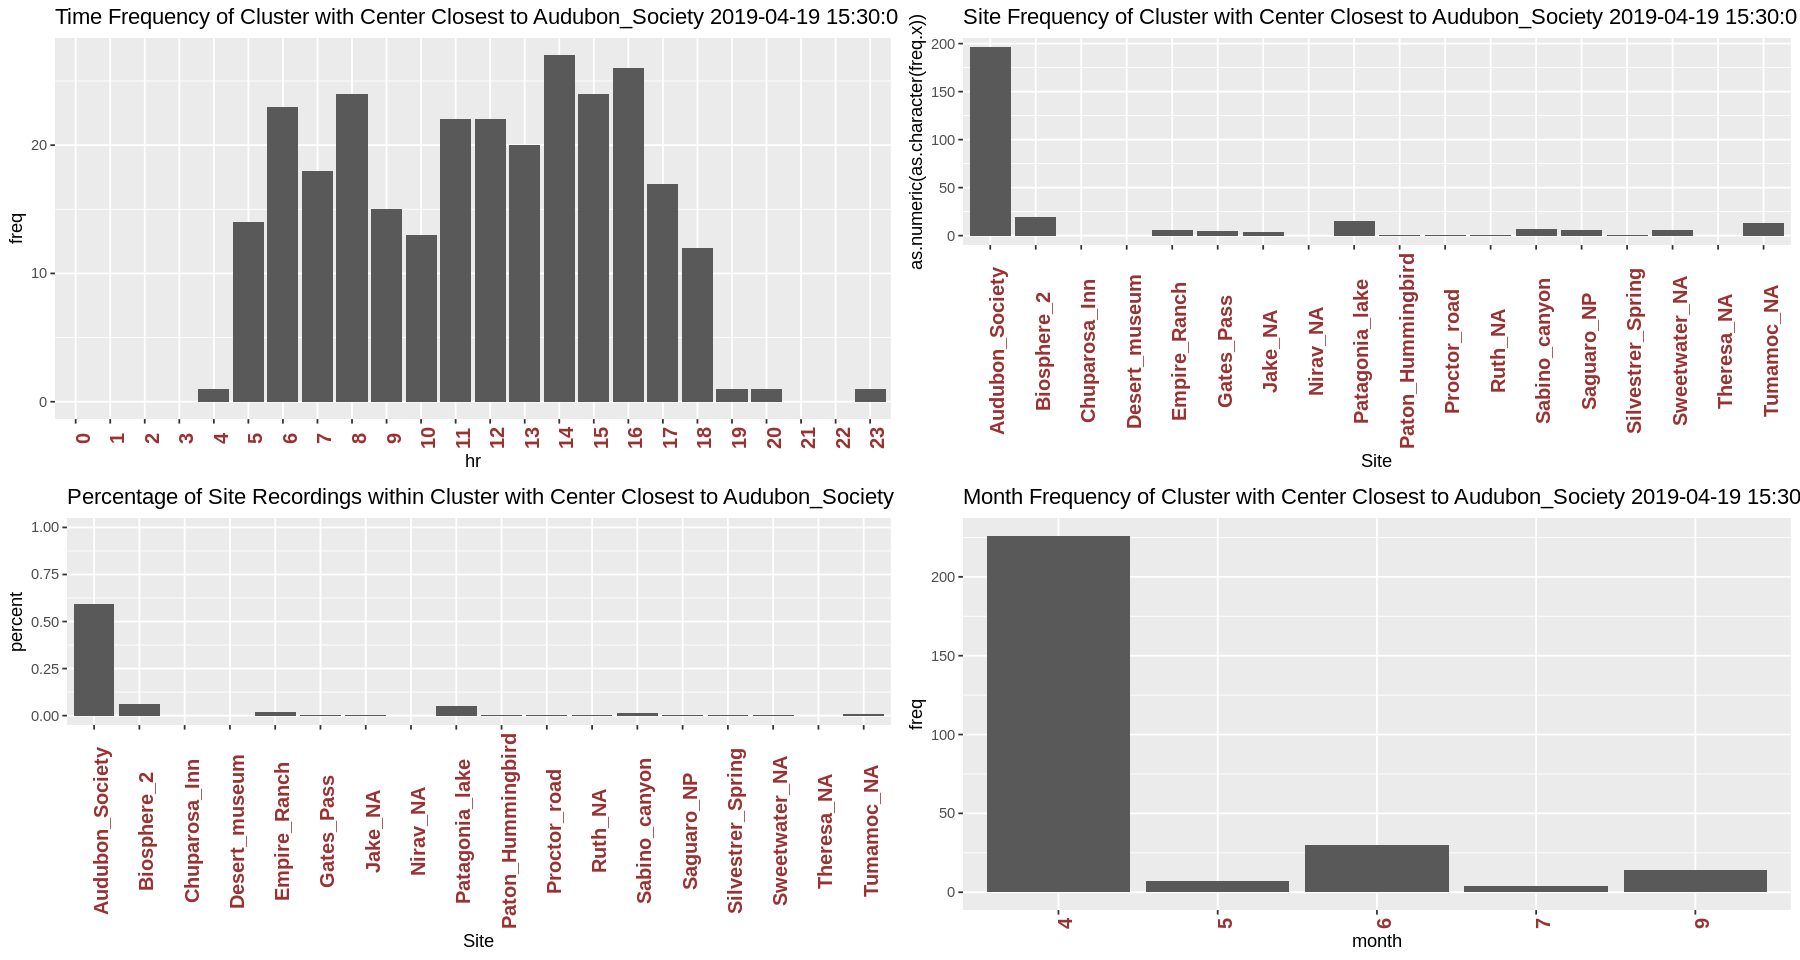

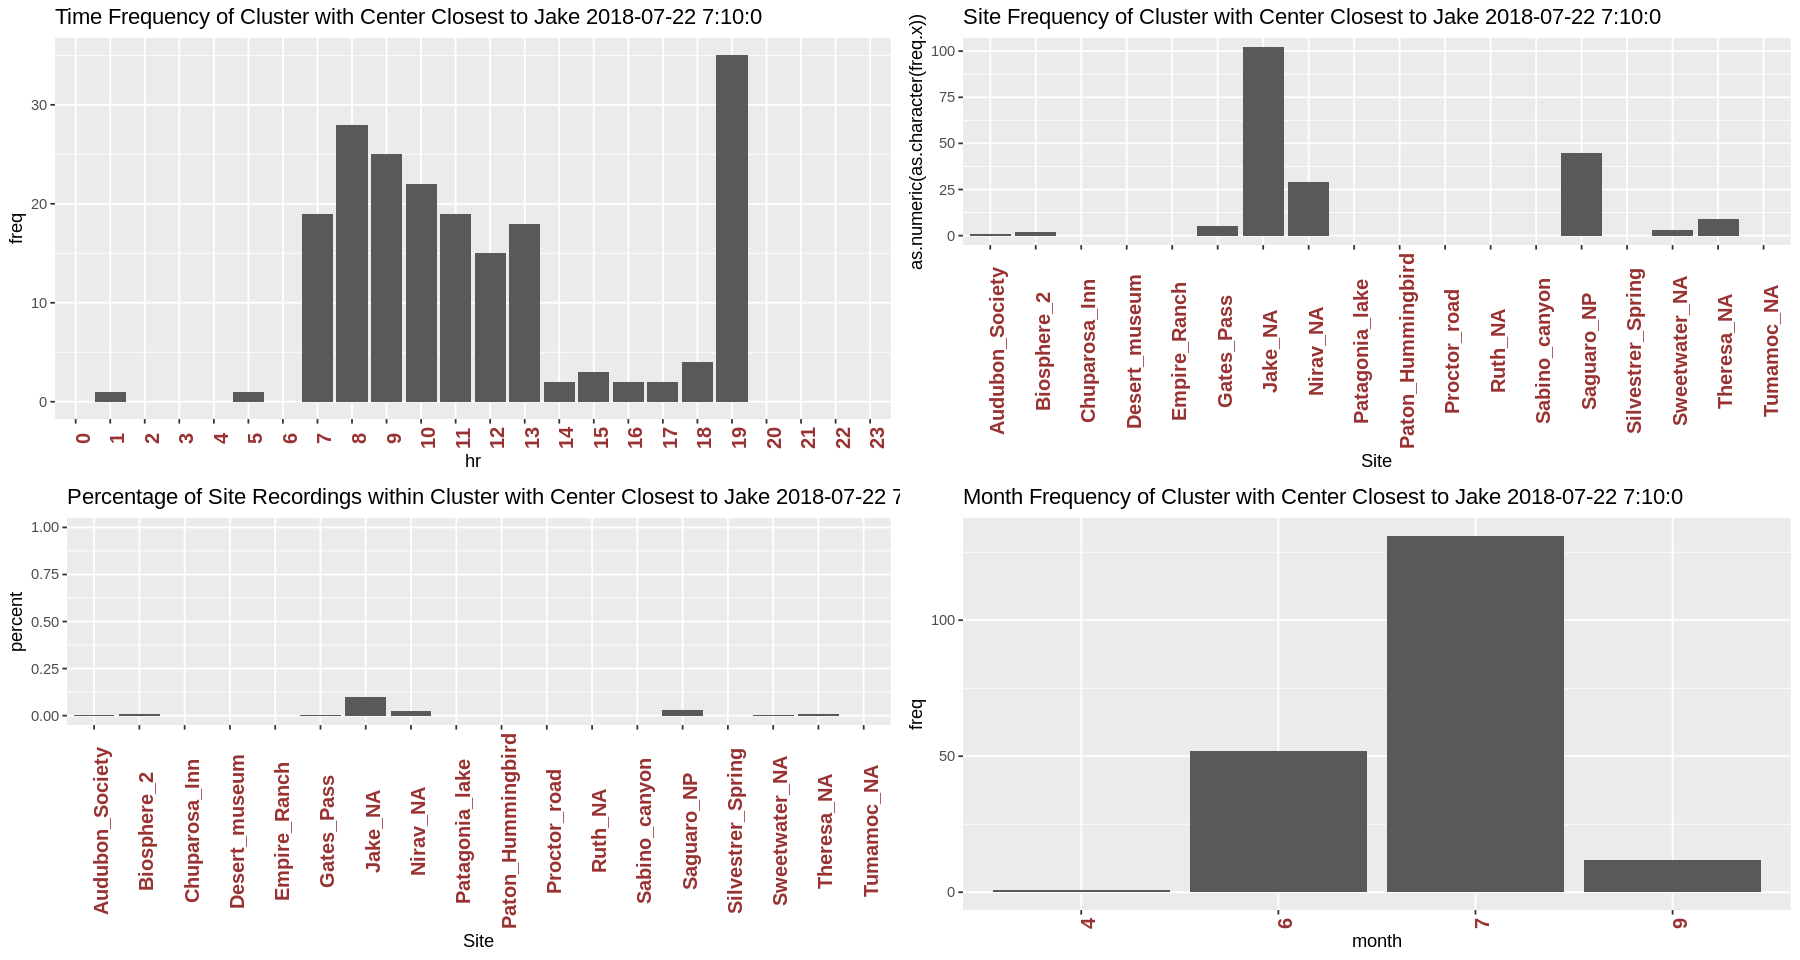

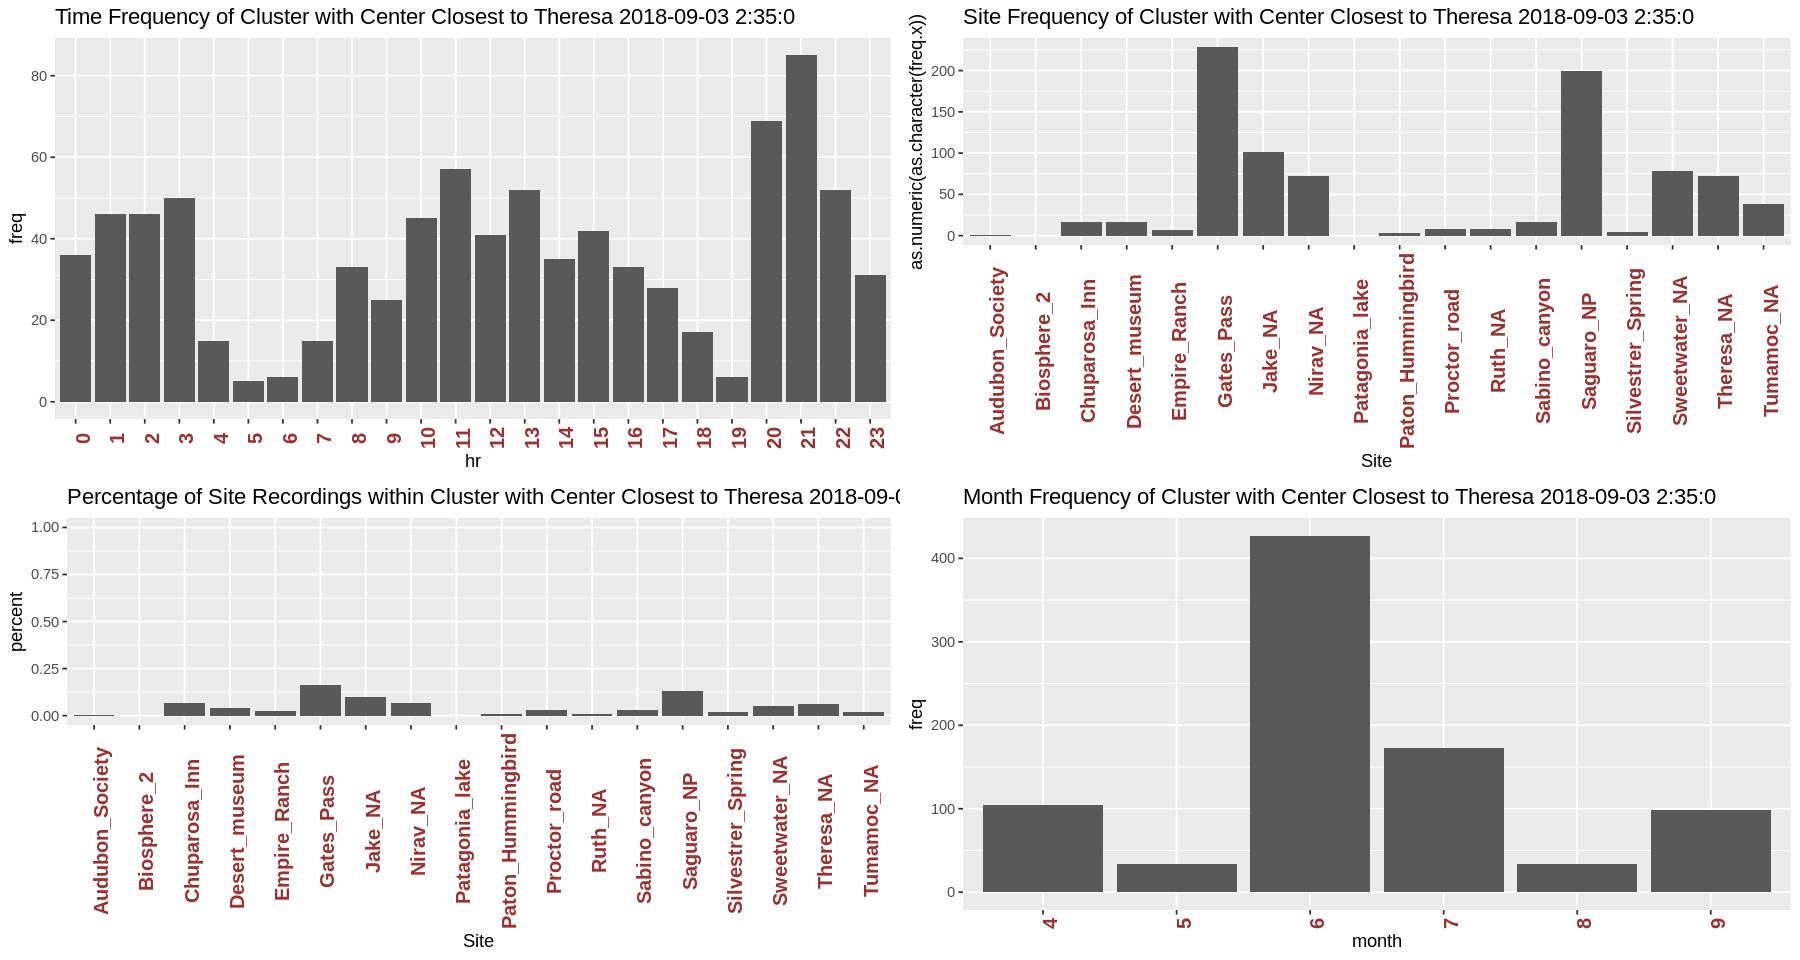

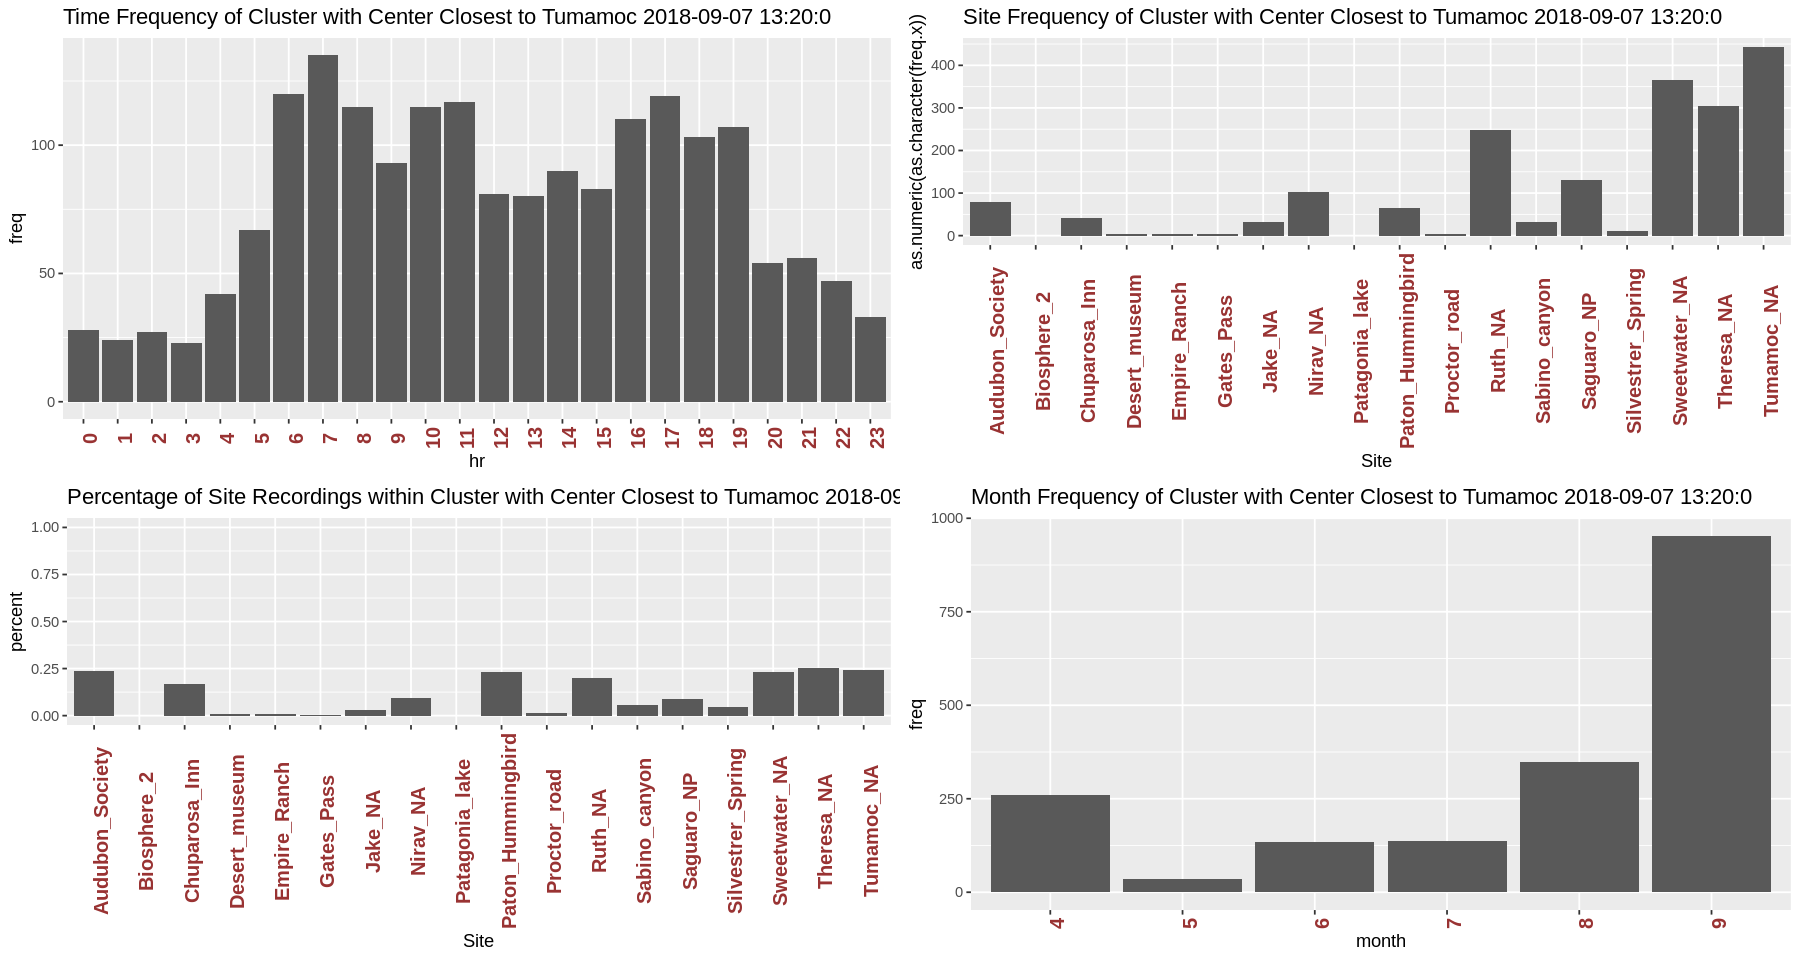

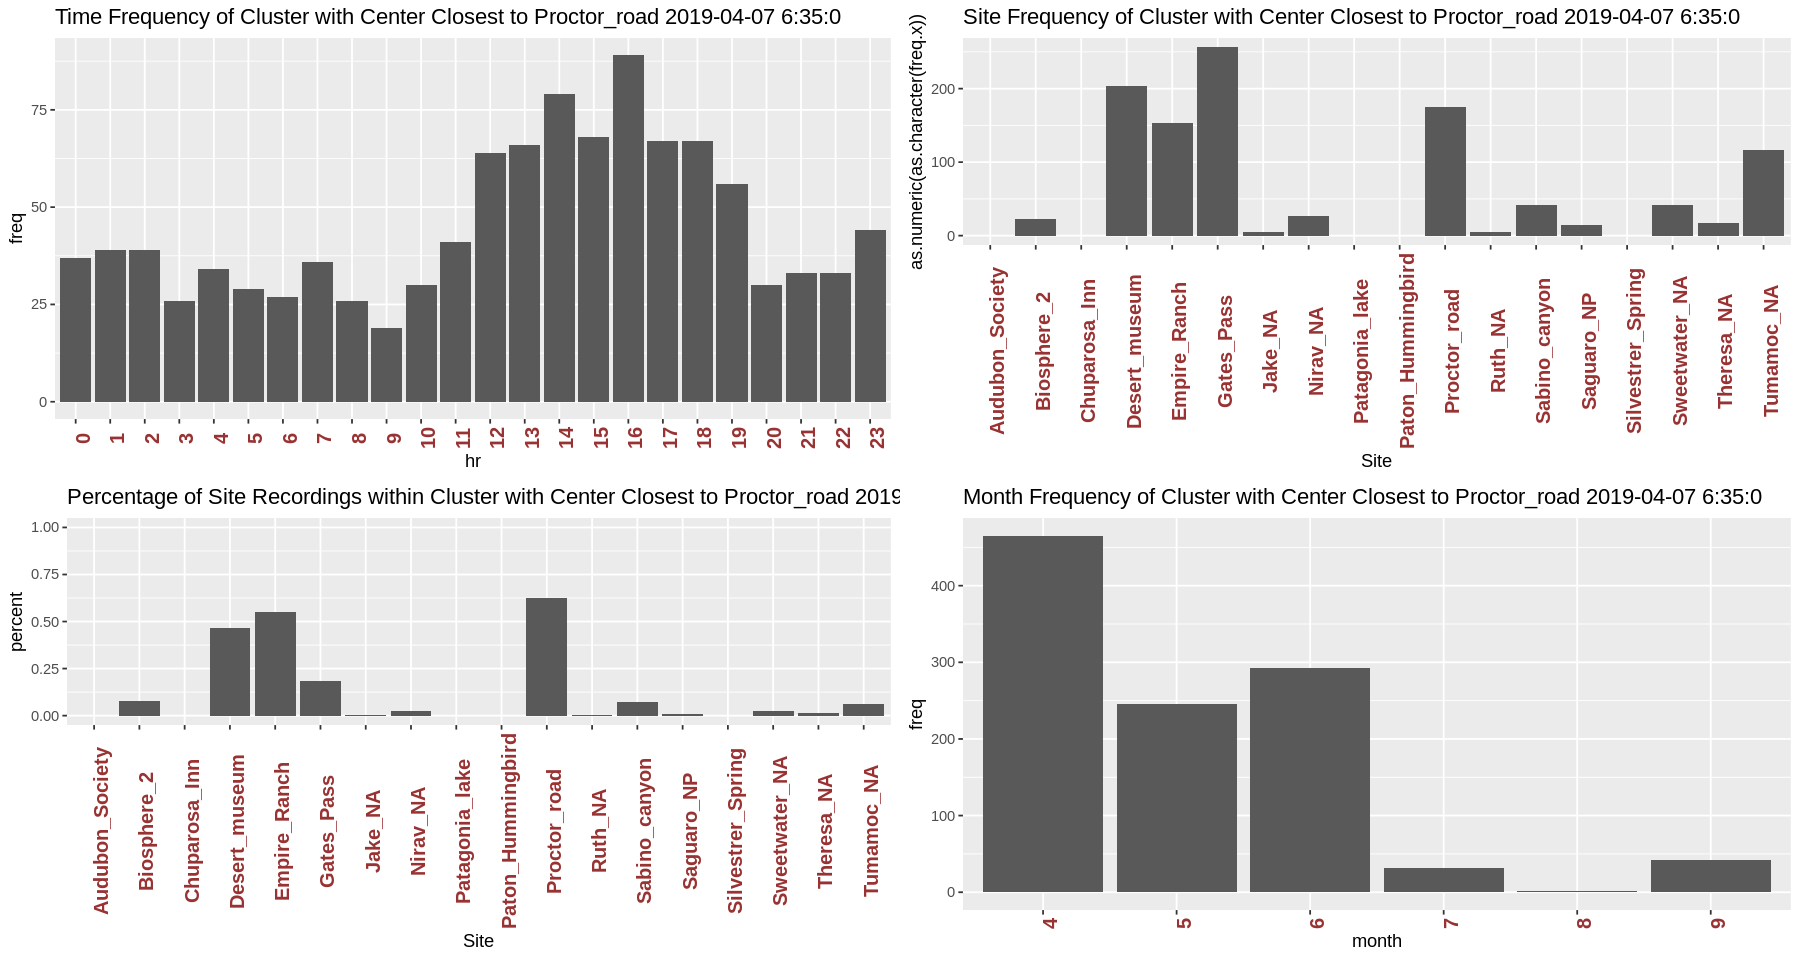

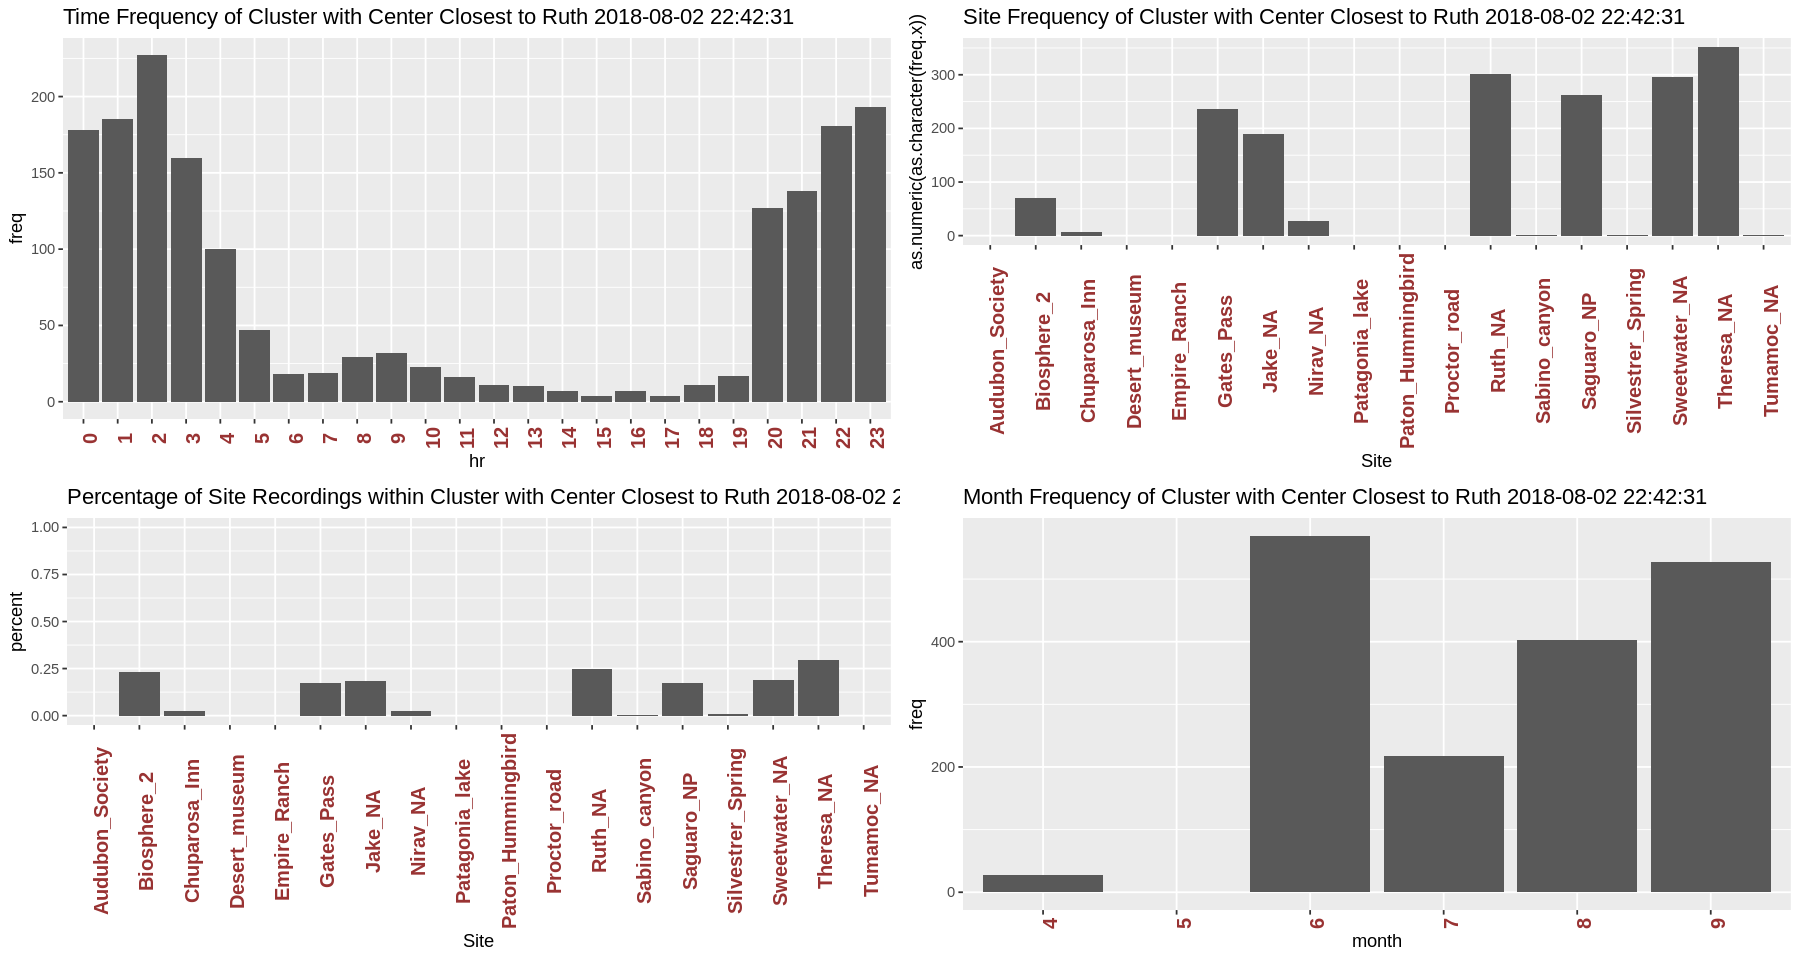

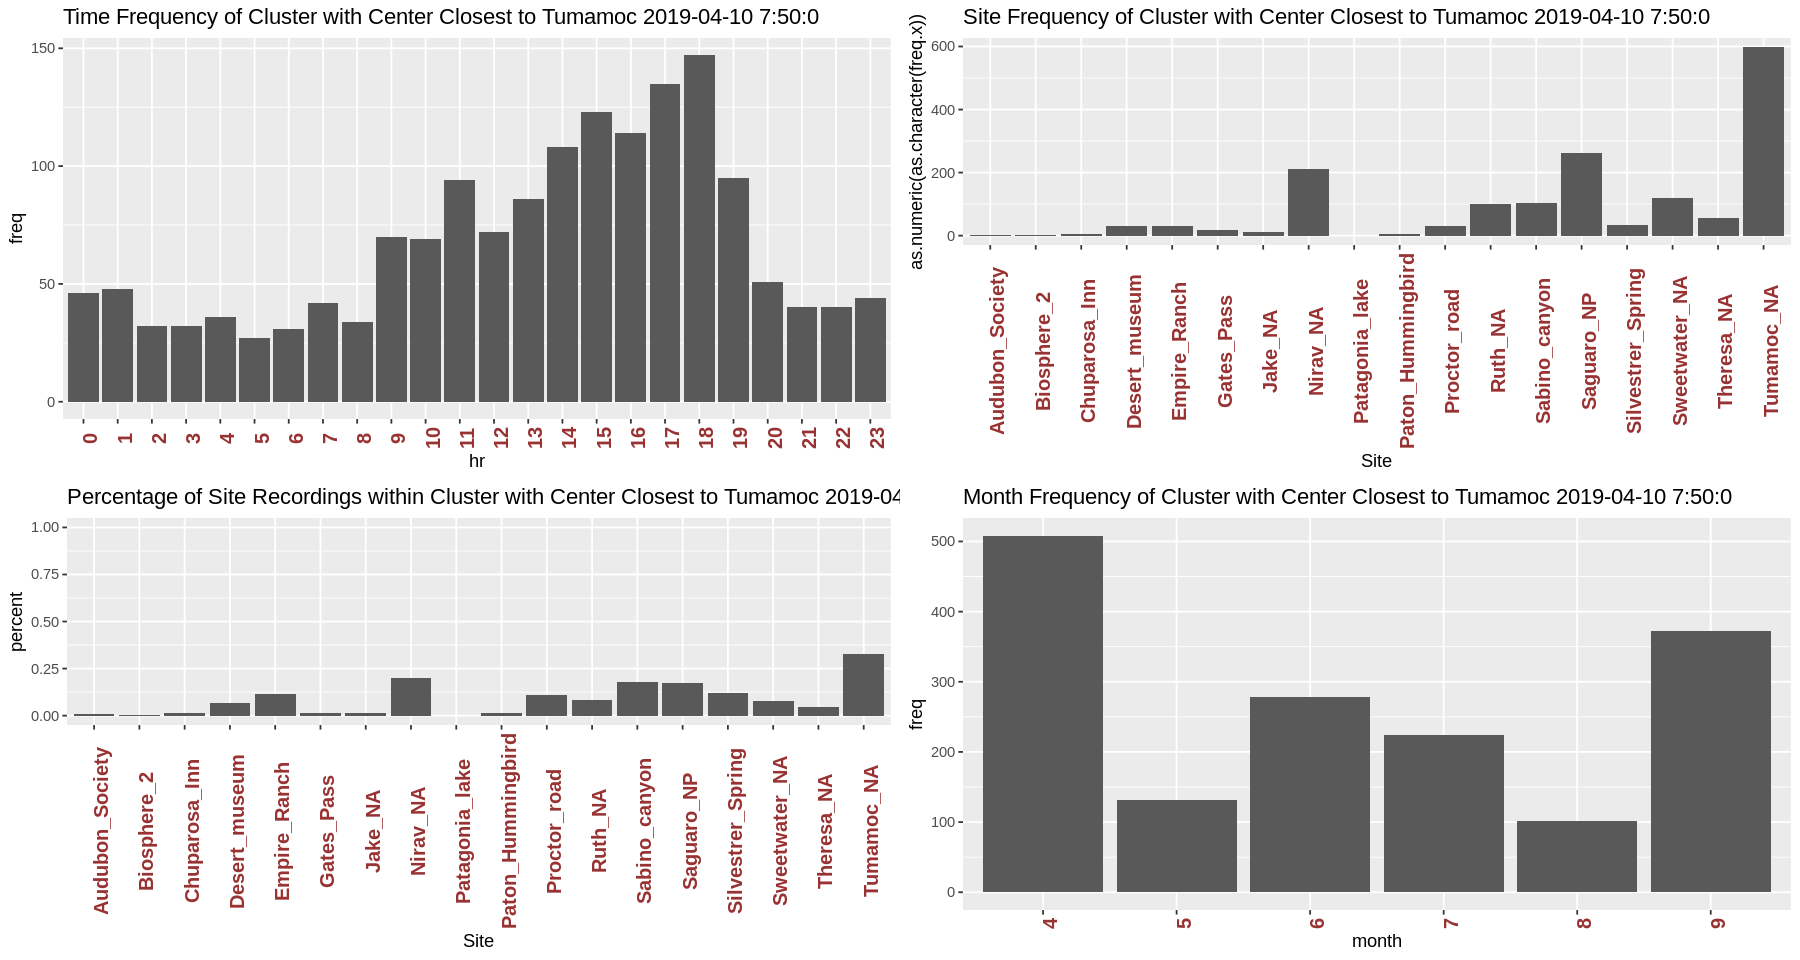

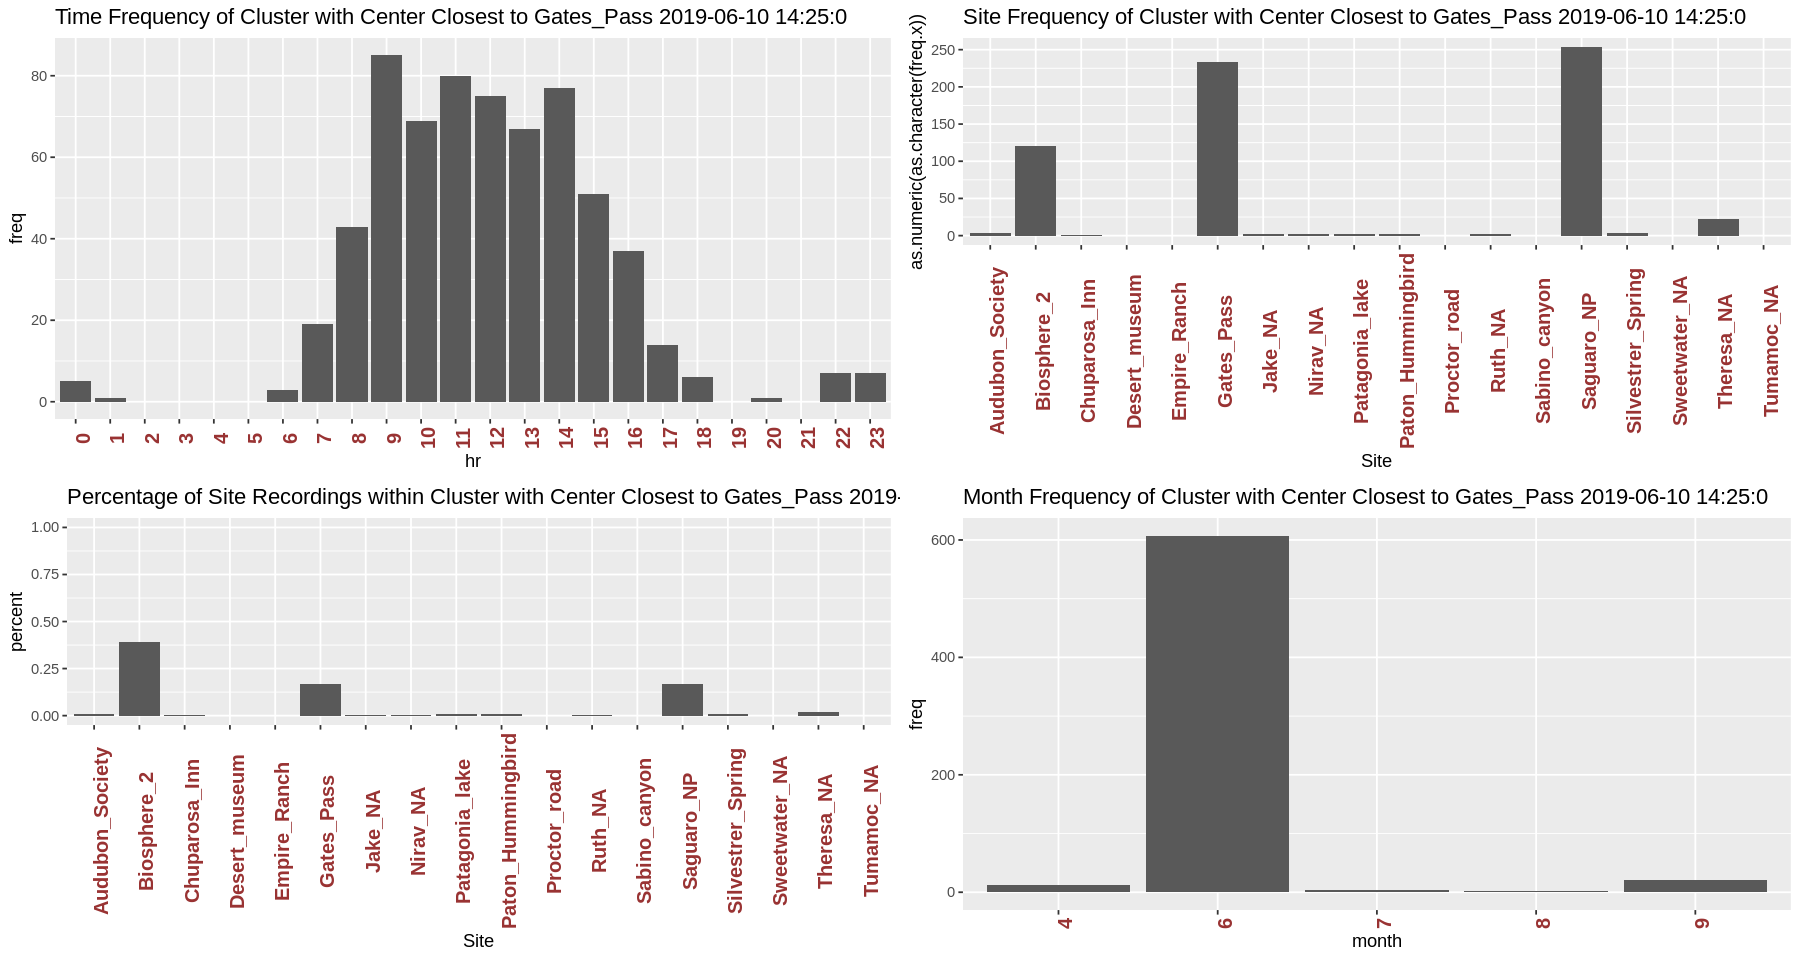

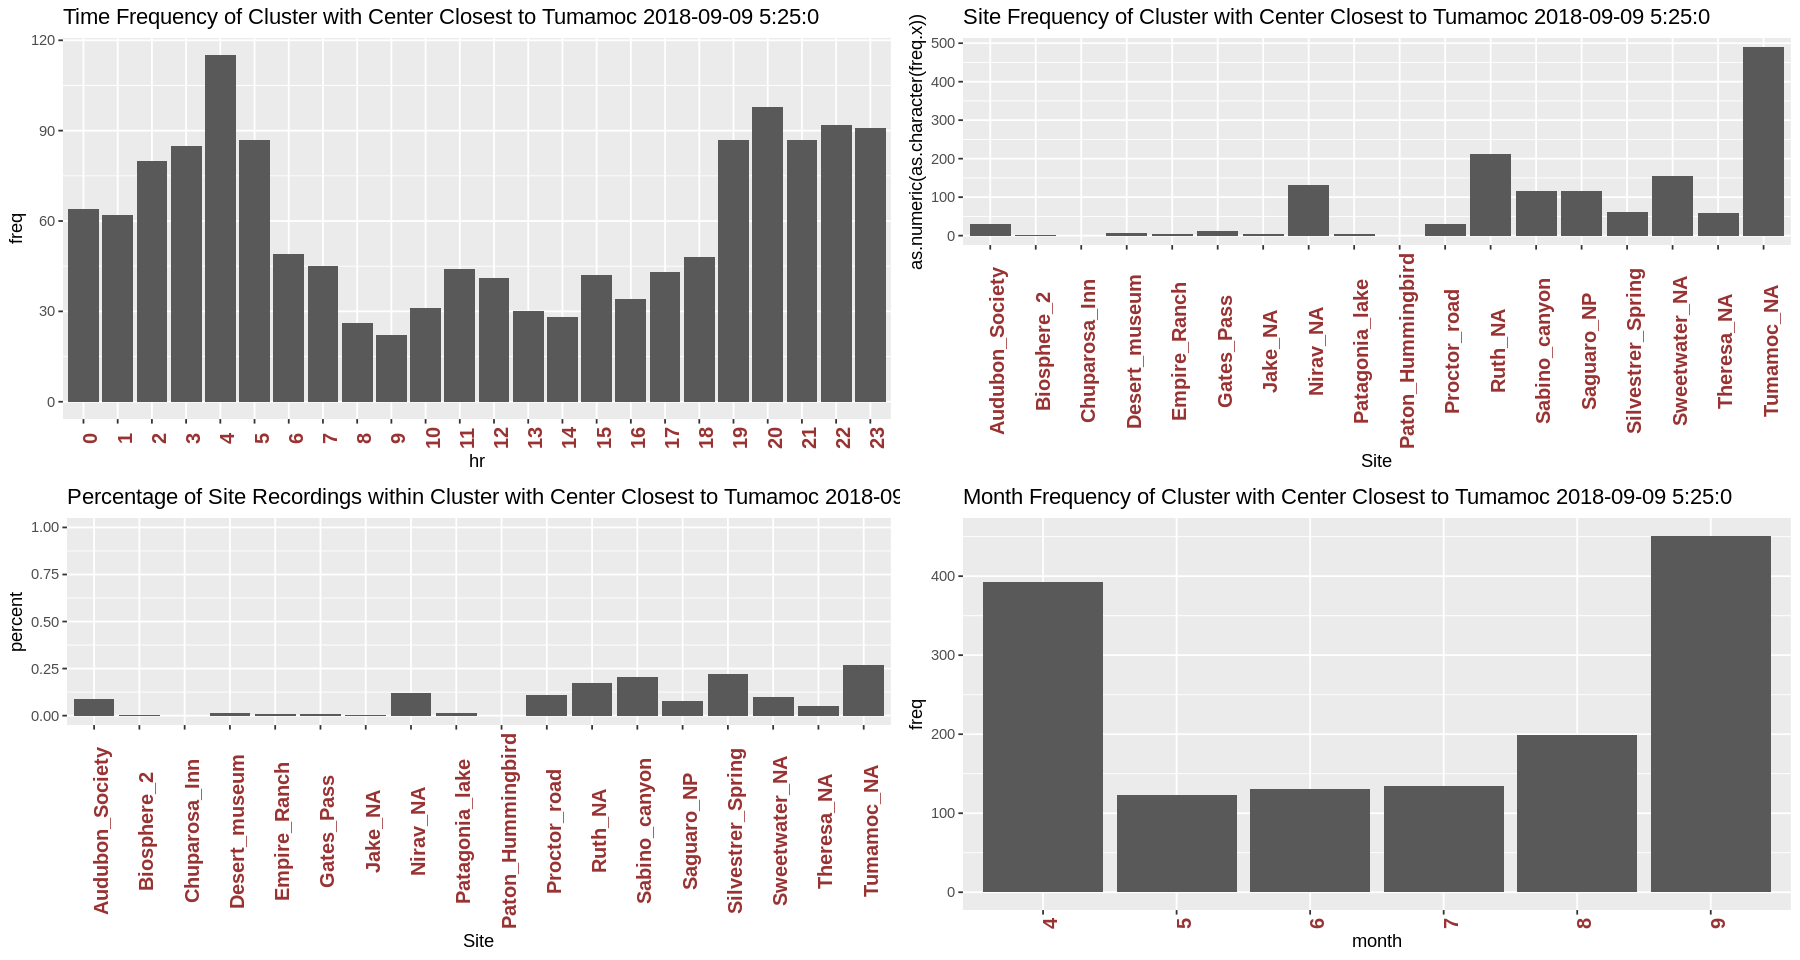

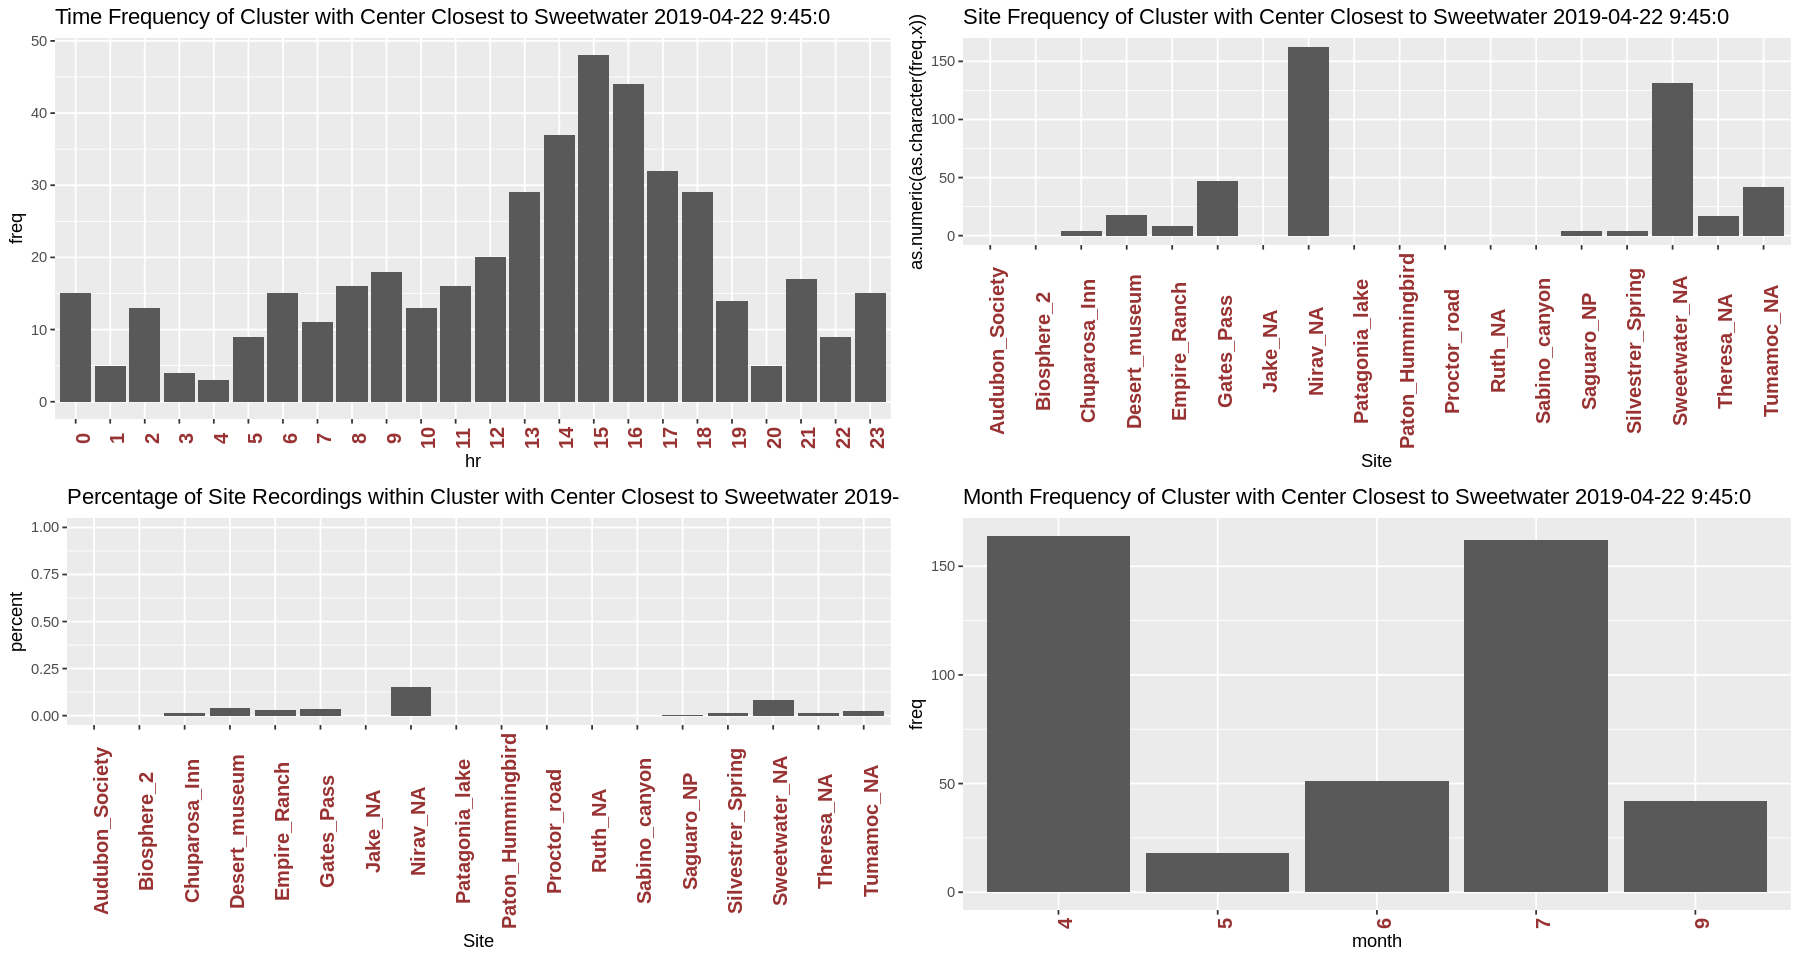

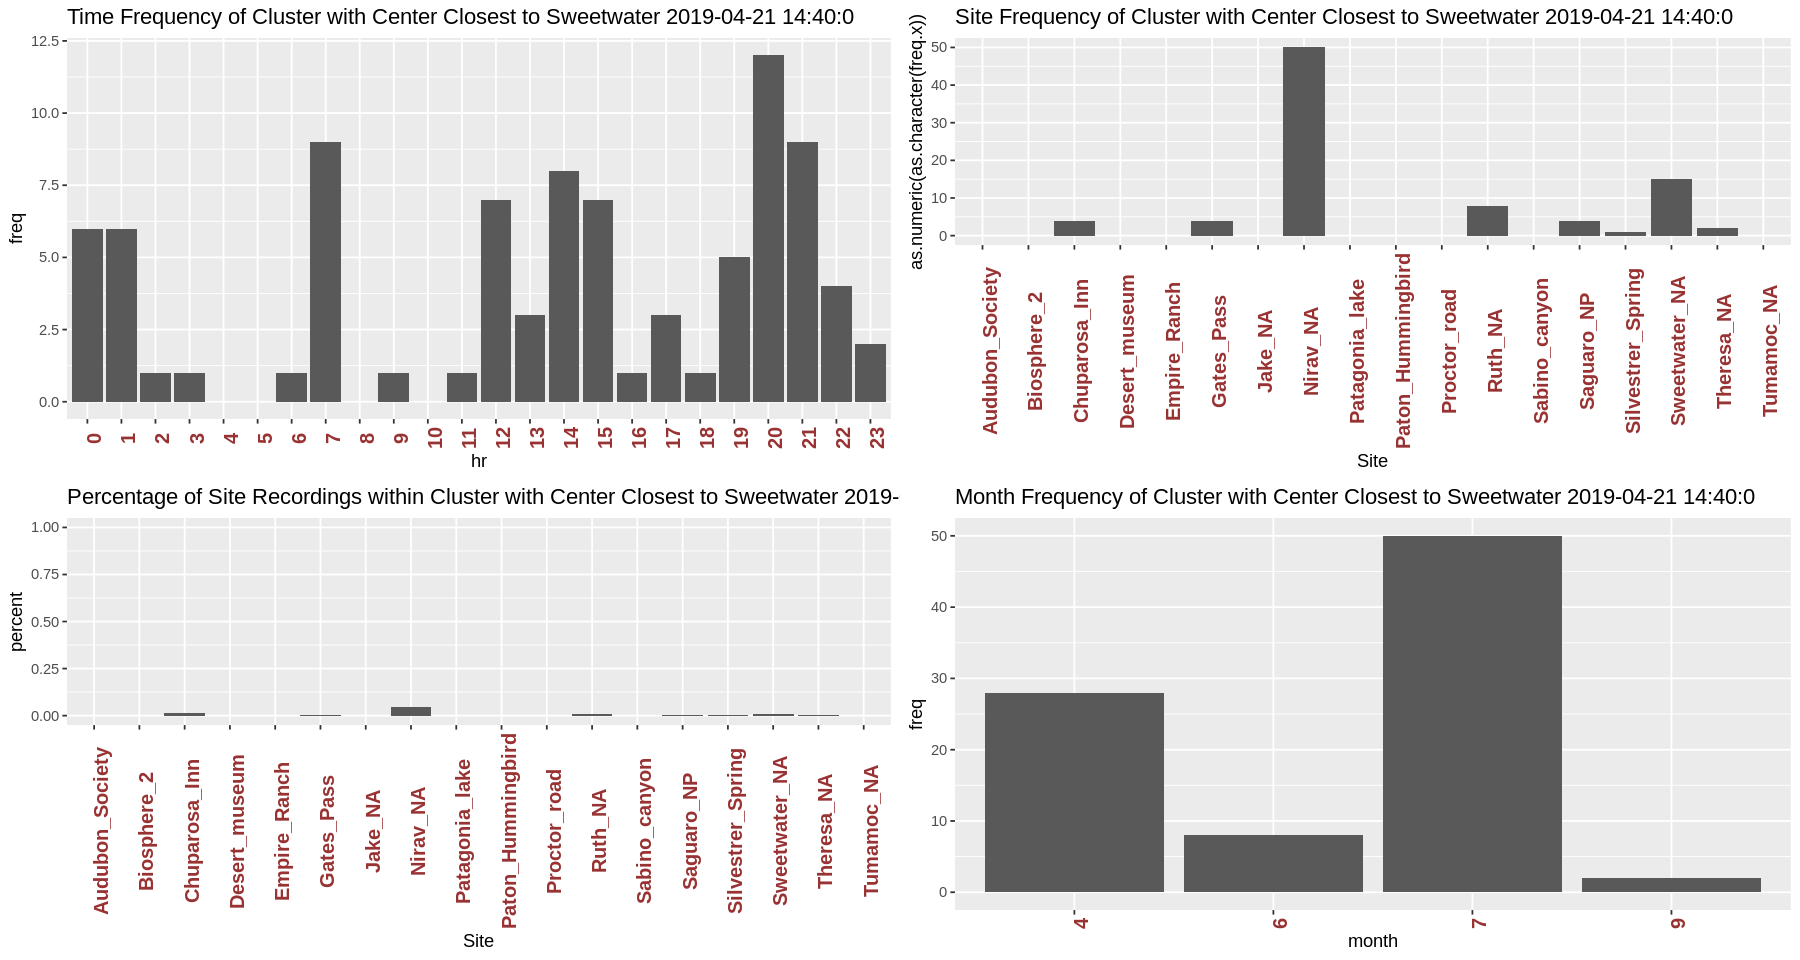

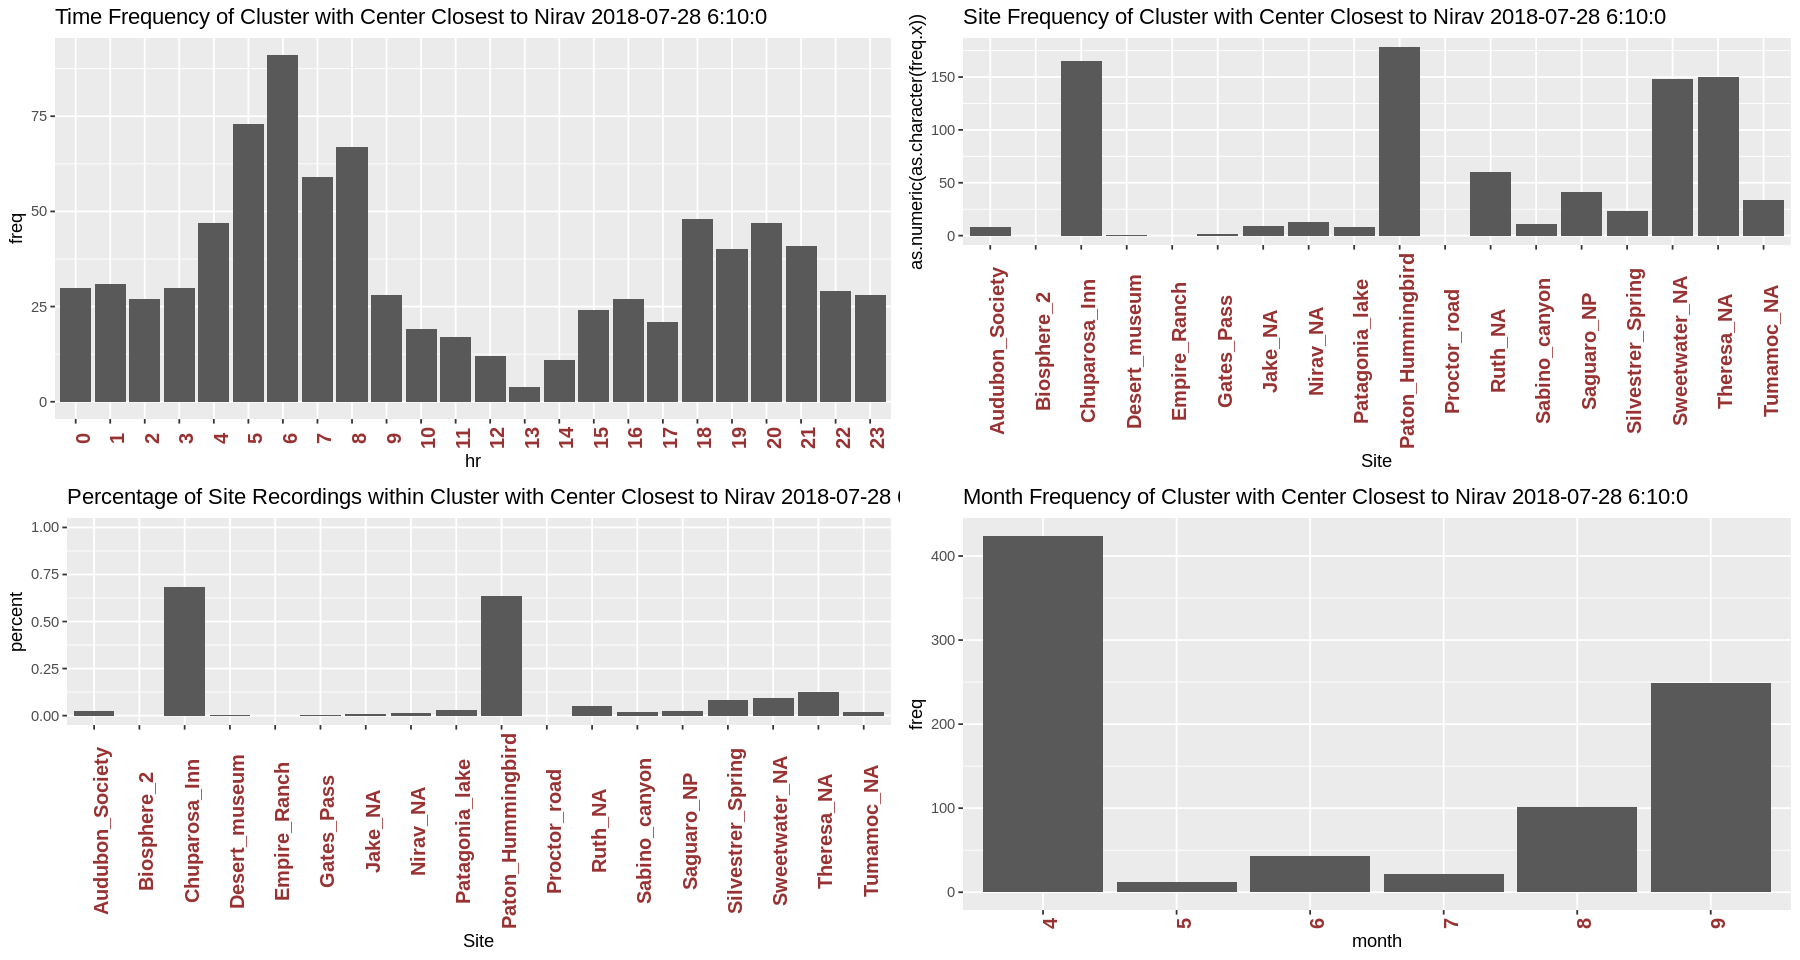

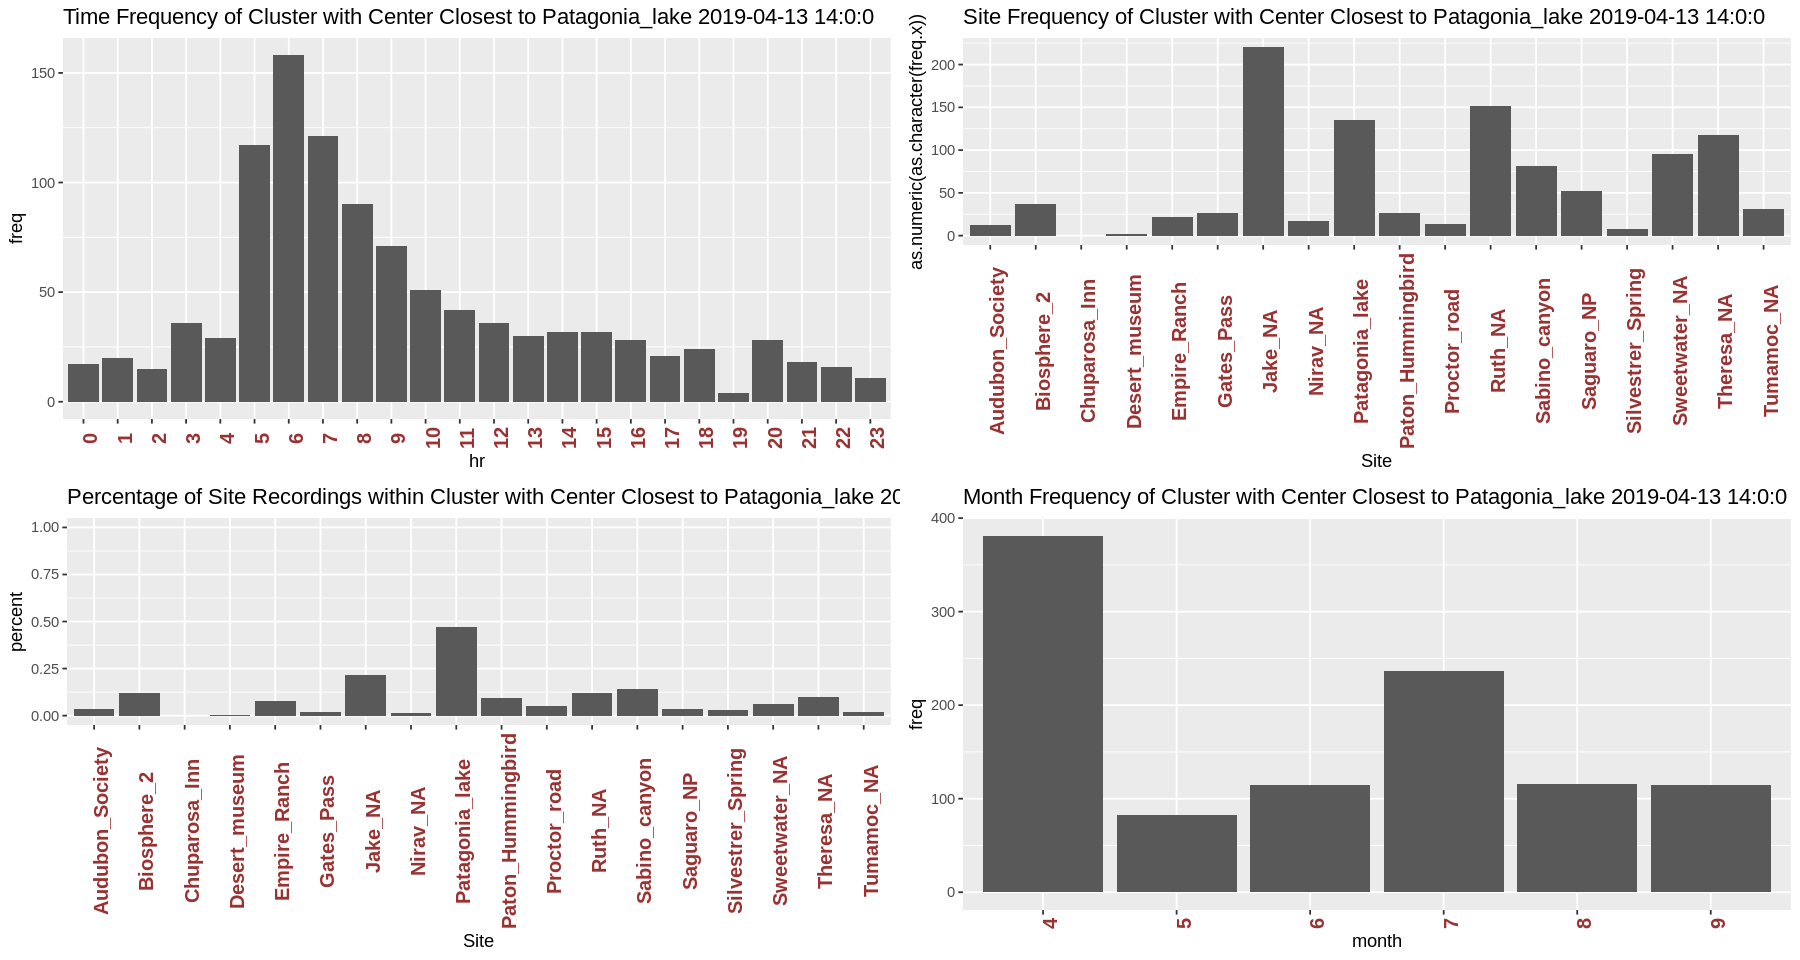

In [74]:
# K-Means Clustering with 10 clusters
fit <- kmeans(index_data[,-(1:6)],15,iter.max=30)
fit$size
fit$centers
# Cluster Plot against 1st 2 principal components

# vary parameters for most readable graph
clusplot(index_data[,-(1:6)], fit$cluster, color=FALSE, shade=FALSE,
   labels=2, lines=0)

histogram_plotter(fit,data.frame(index_data, fit$cluster) )
added_clust_two <- data.frame(added_clust_one, fit$cluster)


In [75]:
names(added_clust_two)[names(added_clust_two) == "fit.cluster"] <- "cluster..nine..clusters"
names(added_clust_two)[names(added_clust_two) == "fit.cluster.1"] <- "cluster..fifteen..clusters"
names(added_clust_two)[names(added_clust_two) == "fit.cluster.1"] <- "nrows..."
write.csv(added_clust_two,"indices_with_clusters.csv", row.names = FALSE)

In [ ]:
indices.pca <- prcomp(index_data[,-(1:6)], scale = TRUE)
fviz_eig(indices.pca)

Scatterplots for every pair of bioindices. The colorings represent the month of the data point and the hour of the day, respectively. 

CAUTION: This may not be a good visualization of the class makeup; some classes may be covering up others; Analyse colorings with care!

The almost perfect correlation between spectral entropy and acoustic entropy suggests we should drop one of them. 

There is obviously some dependency between acoustic diversity and acoustic evenness, but it is not clear if dropping one of them would reduce the efficacy of the clustering/PCA. I believe that because a powerful enough neural net should be able to implicitly transform one of these indices into the other, it is likely that dropping one of them should not worsen performance of any sort of neural model. 

In [ ]:
months <- sapply(index_data$Date....as.Date.character....format.....Y..m..d..,month_getter)
clPairs(index_data[,-(1:6)],months)
clPairs(index_data[,-(1:6)],index_data$Site)

In [ ]:
mix_fit <- Mclust(index_data[,-(1:6)])
mix_fit

In [ ]:
mix_fit$parameters

The $pro vector indicates the mixing proportion of the optimal model is less than 1% 